In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import random
random.seed(29)
subjects = random.sample(range(1,32), 5)

In [3]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size):
        super(ResidualBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.activation1 = nn.ReLU()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, stride= 1, padding= 2)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.activation2 = nn.ReLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, stride= 1, padding= 2)
    
    def forward(self,x):
        residual  = torch.clone(x)
        x = self.bn1(x)
        x = self.activation1(x)
        x = self.conv1(x)
        x = self.conv2(self.activation2(self.bn2(x)))
        residual = residual.unsqueeze(0)
        residual = nn.functional.interpolate(residual, size = [x.shape[1], x.shape[2], x.shape[3]])
        residual = residual.squeeze(0)
        x += residual
        return x
     
class ModelSubDep(nn.Module):

    def __init__(self):
        super(ModelSubDep, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 5, out_channels = 32, kernel_size= 3, stride= 1, padding= 2)
        self.resblock1 = ResidualBlock(32,32,5)
        self.resblock2 = ResidualBlock(32,64,5)
        self.resblock3 = ResidualBlock(64,128,5)
        self.avgpool = nn.AdaptiveAvgPool2d((15,15))
        self.linear1 = nn.Linear(15*15*128, 1024)
        self.drop1 = nn.Dropout(0.2)
        self.linear2 = nn.Linear(1024, 512)
        self.drop2 = nn.Dropout(0.2)
        self.linear3 = nn.Linear(512, 2)
        self.softmax = nn.Softmax(dim = 1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.resblock1(x)
        x = self.resblock2(x)
        x = self.resblock3(x)
        x = self.avgpool(x)
        F = nn.Flatten()
        x = F(x)
        x = self.linear1(x)
        x = self.drop1(x)
        x = self.linear2(x)
        x = self.drop2(x)
        x = self.linear3(x)
        x = self.softmax(x)
        return x

In [4]:
import scipy
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import pandas as pd
from sklearn.model_selection import StratifiedKFold as skf

class Dataset(Dataset):
    def __init__(self, data, info):
        #data loading
        self.x = data
        self.y = info
        self.n_samples = data.shape[0]


    def __getitem__(self,index):
        t1 = self.x[index]
        t2 = self.y[index]
        t1 = torch.tensor(t1)
        t1 = t1.permute((2,0,1))
        t2 = torch.tensor(t2)
        return (t1,t2)
    
    def __len__(self):
        return self.n_samples
    
data = scipy.io.loadmat('/home/desktop/Desktop/22104412_Docs/EEG-COGMusic/Baseline/datasets/COH_PLI_PSD_s15.mat')

In [5]:
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'data', 'labels_kfold', 'valence', 'arousal', 'EEGNet'])

In [6]:
x = data['data']
labels_skf = data['labels_kfold']
labels = data['arousal']

In [7]:
labels.shape

(40, 115, 2)

In [8]:
x.shape

(40, 115, 32, 32, 5)

In [ ]:
indices = []

In [9]:
# x_n = np.zeros((40,115,32,32,3))
# print(x_n.shape)
# for trial in range(x_n.shape[0]):
#     for sample in range(x_n.shape[1]):
#         x_n[trial,sample,:,:,0] = x[trial,sample,:,:,0]+np.transpose(x[trial,sample,:,:,1])
#         x_n[trial,sample,:,:,1] = x[trial,sample,:,:,2]+np.transpose(x[trial,sample,:,:,3])
#         x_n[trial,sample,:,:,2] = x[trial,sample,:,:,4]+np.transpose(x[trial,sample,:,:,5])
#     print(f'Completed trial {trial}')

In [10]:
# x = x[:,:,0:128,:,np.newaxis]
# x.shape

In [11]:
dt = x
labels = labels
trainLoss={}
valLoss = {}
trainAcc = {}
valAcc = {}

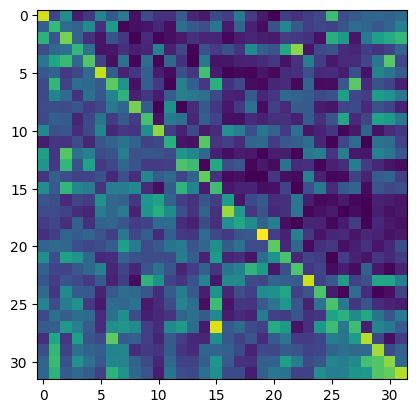

In [12]:
plt.imshow(dt[0,0,:,:,1])

In [13]:
labels_skf.shape

(40, 2)

In [14]:
l_skf = np.zeros([40,1])
l_skf[np.where(labels_skf[:,0]>5)[0]] = 1

In [15]:
l_skf

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [16]:
kf = skf(n_splits = 5)
l = []
ind = []
for k,(train_index,test_index) in enumerate(kf.split(dt,l_skf)):
    labelsTr, labelsV = labels[train_index], labels[test_index]   
    l.append({'train': labelsTr,
            'valid': labelsV})
    ind.append([train_index,test_index])

In [17]:
counts = []
for fold in range(len(l)):
    count_hv_t = 0
    count_lv_t = 0
    count_hv_v = 0
    count_lv_v = 0
    l_fold = l[fold]
    for label in l_fold['train']:
        if (label == [0.,1.]).all():
            count_hv_t += 1
        else:
            count_lv_t +=1
    for label in l_fold['valid']:
        if (label == [0.,1.]).all():
            count_hv_v += 1
        else:
            count_lv_v +=1
    counts.append([count_hv_t,count_lv_t,count_hv_v,count_lv_v])    
    print(f'Fold {fold} completed')




Fold 0 completed
Fold 1 completed
Fold 2 completed
Fold 3 completed
Fold 4 completed


In [18]:
df = pd.DataFrame(data=counts, columns= ['hv_t','lv_t','hv_v','lv_v'])

In [19]:
print(df)

   hv_t  lv_t  hv_v  lv_v
0    17    15     2     6
1    14    18     5     3
2    15    17     4     4
3    17    15     2     6
4    13    19     6     2


<Axes: >

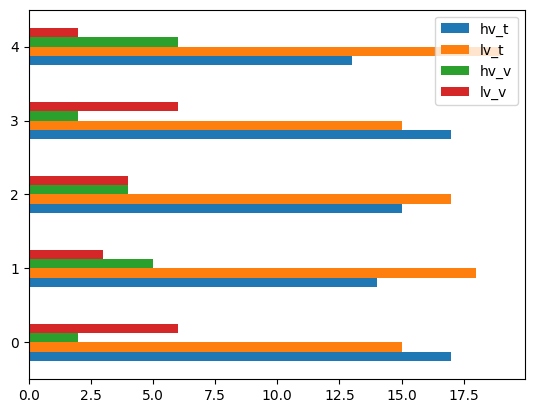

In [20]:
df.plot.barh()

In [21]:
l_skf

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [22]:
dt.shape

(40, 115, 32, 32, 5)

In [23]:
labels.shape

(40, 115, 2)

In [24]:
kf = skf(n_splits = 5)
log_pred_dict = {}
for k,(train_index,test_index) in enumerate(kf.split(dt, l_skf)):
    print(f'Fold {k+1} running')
    dataTr, dataV = np.concatenate(dt[train_index],0), np.concatenate(dt[test_index],0)
    labelsTr, labelsV = np.concatenate(labels[train_index],0), np.concatenate(labels[test_index],0)
    tL = []
    vL = []
    tAV = []
    vAV = []
    # testAC = []
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model = ModelSubDep()
    model = model.to(device)
     # Define your weights as a tensor
    criterion = nn.CrossEntropyLoss()
    optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum= 0.9)
    trainDS = Dataset(dataTr, labelsTr)
    trainDL = DataLoader(dataset = trainDS, batch_size = 100, shuffle = True)
 
    valDS = Dataset(dataV, labelsV)
    valDL = DataLoader(dataset = valDS, batch_size = 100, shuffle = True)
    
    testDS = Dataset(dataV, labelsV)
    testDL = DataLoader(dataset = testDS, batch_size = 100)
    # criterion2 = FocalLoss(gamma=0.1)
    num_epochs = 100
    batchsize = 100
    l2_lambda = 0.001
    best_va = 0
    for epoch in range(num_epochs):
        with tqdm(trainDL, unit='batch') as tepoch:
            trainAccuracy_valence = 0
            trainAccuracy_arousal = 0
            totalLoss = 0
            model.train()
            for imagest,lab in tepoch:
                imagest = imagest.to(device)
                lab = lab.to(device)
                optimizer_ft.zero_grad()
                outputs = (model(imagest.float()))
                _,predindex = torch.max(outputs, dim = 1)
                _,labindex = torch.max(lab, dim = 1)
                loss = criterion(outputs,lab.float())
                if torch.isnan(loss):
                    print('Dead!')
                # loss2 = criterion2(outputs,labindex)
                # loss = 0.5*loss2 + loss1
                l2_reg = 0.0
                for param in model.parameters():
                    l2_reg += torch.norm(param, p=2)  # L2 norm of the parameter
                loss += l2_lambda * l2_reg
                loss.backward()
                totalLoss+=loss.item()
                optimizer_ft.step()
                y_valence = (predindex==labindex).sum().item()
                batchAccuracy_valence = y_valence/batchsize
                trainAccuracy_valence += batchAccuracy_valence
                totaltrainAccuracybatch_valence = trainAccuracy_valence/len(trainDL)
                tepoch.set_postfix(loss=loss.item(),totalLoss =totalLoss/len(trainDL), TrainAccuracyPerBatch_valence= 100.*totaltrainAccuracybatch_valence)      
            model.eval()
            with torch.no_grad():
                  with tqdm(valDL, unit='batch') as tepoch:
                        total = 0
                        correct_valence = 0
                        correct_arousal = 0
                        val_loss = 0
                        for imagesv,lab in tepoch:
                            imagesv = imagesv.to(device)
                            labelsv = lab.to(device)
                            outval = (model(imagesv.float()))
                            _,predindexval = torch.max(outval,dim = 1)
                            _,labvalindex = torch.max(labelsv,dim = 1)
                            total += labelsv.size(0)
                            correct_valence += (predindexval == labvalindex).sum().item()
                            lossv = criterion(outval,labvalindex)
                            val_loss+= lossv.item()
        print('Epoch [{}], Loss_t: {:.4f},Loss_v: {:.4f}, train_acc_v:{:.4f}, val_acc_v:{:.4f}'.format(epoch, totalLoss/len(trainDL), val_loss/len(valDL), 100.*totaltrainAccuracybatch_valence,
                                                                                                                      100.*correct_valence/total))
        tL.append(totalLoss/len(trainDL))
        vL.append(val_loss/len(valDL))
        tAV.append(100.*totaltrainAccuracybatch_valence)
        vAV.append( 100.*correct_valence/total)
    trainLoss[str(k)] = tL
    valLoss[str(k)] = vL
    trainAcc[str(k)] = tAV
    valAcc[str(k)] = vAV
    model.eval()
    pt = []
    lt = []
    with torch.no_grad():
        with tqdm(testDL, unit='batch') as tepochtst:
            for imagestst,labt in tepochtst:
                imagestst = imagestst.to(device)
                labelst = labt.to(device)
                outt = (model(imagestst.float()))
                _,predt = torch.max(outt,dim=1)
                _,labti = torch.max(labelst,dim =1)
                pt.append(predt)
                lt.append(labti)
    log_pred_dict[str(k)] = {'trails': test_index,
                             'predicted': pt,
                             'ground truth': lt}
tL = np.array(list(trainLoss.values()))
vL = np.array(list(valLoss.values()))
tAV = np.array(list(trainAcc.values()))
vAV = np.array(list(valAcc.values()))

Fold 1 running


100%|██████████| 10/10 [00:00<00:00, 34.03batch/s]


Epoch [0], Loss_t: 0.7876,Loss_v: 0.6921, train_acc_v:55.9459, val_acc_v:52.2826


100%|██████████| 10/10 [00:00<00:00, 34.48batch/s]


Epoch [1], Loss_t: 0.7592,Loss_v: 0.8321, train_acc_v:60.9459, val_acc_v:29.6739


100%|██████████| 10/10 [00:00<00:00, 34.36batch/s]


Epoch [2], Loss_t: 0.7467,Loss_v: 0.7209, train_acc_v:62.6757, val_acc_v:47.9348


100%|██████████| 10/10 [00:00<00:00, 34.99batch/s]


Epoch [3], Loss_t: 0.7393,Loss_v: 0.8043, train_acc_v:63.9459, val_acc_v:38.2609


100%|██████████| 10/10 [00:00<00:00, 34.33batch/s]


Epoch [4], Loss_t: 0.7276,Loss_v: 0.7743, train_acc_v:66.1081, val_acc_v:41.1957


100%|██████████| 10/10 [00:00<00:00, 34.45batch/s]


Epoch [5], Loss_t: 0.7227,Loss_v: 0.8427, train_acc_v:67.0000, val_acc_v:34.3478


100%|██████████| 10/10 [00:00<00:00, 35.10batch/s]


Epoch [6], Loss_t: 0.7149,Loss_v: 0.6834, train_acc_v:67.8919, val_acc_v:57.8261


100%|██████████| 10/10 [00:00<00:00, 34.71batch/s]


Epoch [7], Loss_t: 0.7072,Loss_v: 0.6836, train_acc_v:69.0270, val_acc_v:57.6087


100%|██████████| 10/10 [00:00<00:00, 34.81batch/s]


Epoch [8], Loss_t: 0.7011,Loss_v: 0.7012, train_acc_v:69.5676, val_acc_v:56.5217


100%|██████████| 10/10 [00:00<00:00, 35.08batch/s]


Epoch [9], Loss_t: 0.6862,Loss_v: 0.6887, train_acc_v:71.7838, val_acc_v:57.2826


100%|██████████| 10/10 [00:00<00:00, 35.34batch/s]


Epoch [10], Loss_t: 0.6759,Loss_v: 0.6564, train_acc_v:73.3784, val_acc_v:61.7391


100%|██████████| 10/10 [00:00<00:00, 34.79batch/s]


Epoch [11], Loss_t: 0.6692,Loss_v: 0.6882, train_acc_v:74.7838, val_acc_v:58.4783


100%|██████████| 10/10 [00:00<00:00, 34.93batch/s]


Epoch [12], Loss_t: 0.6586,Loss_v: 0.7386, train_acc_v:75.3784, val_acc_v:51.5217


100%|██████████| 10/10 [00:00<00:00, 35.36batch/s]


Epoch [13], Loss_t: 0.6426,Loss_v: 0.7509, train_acc_v:77.8649, val_acc_v:51.7391


100%|██████████| 10/10 [00:00<00:00, 35.09batch/s]


Epoch [14], Loss_t: 0.6301,Loss_v: 0.6781, train_acc_v:79.2973, val_acc_v:61.0870


100%|██████████| 10/10 [00:00<00:00, 35.55batch/s]


Epoch [15], Loss_t: 0.6150,Loss_v: 0.7453, train_acc_v:81.5676, val_acc_v:52.7174


100%|██████████| 10/10 [00:00<00:00, 34.75batch/s]


Epoch [16], Loss_t: 0.5948,Loss_v: 0.7309, train_acc_v:84.6757, val_acc_v:55.9783


100%|██████████| 10/10 [00:00<00:00, 34.68batch/s]


Epoch [17], Loss_t: 0.5830,Loss_v: 0.6771, train_acc_v:85.2432, val_acc_v:58.8043


100%|██████████| 10/10 [00:00<00:00, 34.63batch/s]


Epoch [18], Loss_t: 0.5697,Loss_v: 0.8031, train_acc_v:86.5676, val_acc_v:47.6087


100%|██████████| 10/10 [00:00<00:00, 35.78batch/s]


Epoch [19], Loss_t: 0.5561,Loss_v: 0.6918, train_acc_v:87.5676, val_acc_v:58.8043


100%|██████████| 10/10 [00:00<00:00, 35.40batch/s]


Epoch [20], Loss_t: 0.5319,Loss_v: 0.7817, train_acc_v:90.7838, val_acc_v:48.8043


100%|██████████| 10/10 [00:00<00:00, 35.57batch/s]


Epoch [21], Loss_t: 0.5292,Loss_v: 0.6348, train_acc_v:90.0811, val_acc_v:65.2174


100%|██████████| 10/10 [00:00<00:00, 35.07batch/s]


Epoch [22], Loss_t: 0.5074,Loss_v: 0.7324, train_acc_v:92.8649, val_acc_v:56.0870


100%|██████████| 10/10 [00:00<00:00, 35.45batch/s]


Epoch [23], Loss_t: 0.5006,Loss_v: 0.5737, train_acc_v:93.4054, val_acc_v:71.4130


100%|██████████| 10/10 [00:00<00:00, 35.28batch/s]


Epoch [24], Loss_t: 0.5160,Loss_v: 0.7428, train_acc_v:91.1081, val_acc_v:54.8913


100%|██████████| 10/10 [00:00<00:00, 35.24batch/s]


Epoch [25], Loss_t: 0.4873,Loss_v: 0.7586, train_acc_v:94.5676, val_acc_v:53.5870


100%|██████████| 10/10 [00:00<00:00, 35.89batch/s]


Epoch [26], Loss_t: 0.4661,Loss_v: 0.6517, train_acc_v:96.5135, val_acc_v:63.6957


100%|██████████| 10/10 [00:00<00:00, 35.28batch/s]


Epoch [27], Loss_t: 0.4638,Loss_v: 0.6327, train_acc_v:96.6757, val_acc_v:65.4348


100%|██████████| 10/10 [00:00<00:00, 35.53batch/s]


Epoch [28], Loss_t: 0.4547,Loss_v: 0.6893, train_acc_v:97.3243, val_acc_v:59.5652


100%|██████████| 10/10 [00:00<00:00, 35.79batch/s]


Epoch [29], Loss_t: 0.4510,Loss_v: 0.6919, train_acc_v:97.7297, val_acc_v:58.9130


100%|██████████| 10/10 [00:00<00:00, 35.52batch/s]


Epoch [30], Loss_t: 0.4423,Loss_v: 0.7256, train_acc_v:98.3243, val_acc_v:56.1957


100%|██████████| 10/10 [00:00<00:00, 35.94batch/s]


Epoch [31], Loss_t: 0.4428,Loss_v: 0.8667, train_acc_v:98.3784, val_acc_v:41.5217


100%|██████████| 10/10 [00:00<00:00, 35.05batch/s]


Epoch [32], Loss_t: 0.4408,Loss_v: 0.6927, train_acc_v:98.4054, val_acc_v:58.5870


100%|██████████| 10/10 [00:00<00:00, 35.65batch/s]


Epoch [33], Loss_t: 0.4346,Loss_v: 0.7813, train_acc_v:98.9459, val_acc_v:50.0000


100%|██████████| 10/10 [00:00<00:00, 36.47batch/s]


Epoch [34], Loss_t: 0.4307,Loss_v: 0.7691, train_acc_v:99.1351, val_acc_v:52.1739


100%|██████████| 10/10 [00:00<00:00, 32.76batch/s]


Epoch [35], Loss_t: 0.4280,Loss_v: 0.7440, train_acc_v:99.2432, val_acc_v:55.6522


100%|██████████| 10/10 [00:00<00:00, 35.31batch/s]


Epoch [36], Loss_t: 0.4273,Loss_v: 0.7136, train_acc_v:99.2703, val_acc_v:57.1739


100%|██████████| 10/10 [00:00<00:00, 35.15batch/s]


Epoch [37], Loss_t: 0.4269,Loss_v: 0.7329, train_acc_v:99.2703, val_acc_v:55.6522


100%|██████████| 10/10 [00:00<00:00, 35.40batch/s]


Epoch [38], Loss_t: 0.4265,Loss_v: 0.7045, train_acc_v:99.3243, val_acc_v:58.8043


100%|██████████| 10/10 [00:00<00:00, 35.12batch/s]


Epoch [39], Loss_t: 0.4263,Loss_v: 0.7090, train_acc_v:99.3243, val_acc_v:57.8261


100%|██████████| 10/10 [00:00<00:00, 35.25batch/s]


Epoch [40], Loss_t: 0.4260,Loss_v: 0.7408, train_acc_v:99.3514, val_acc_v:55.7609


100%|██████████| 10/10 [00:00<00:00, 35.42batch/s]


Epoch [41], Loss_t: 0.4258,Loss_v: 0.7303, train_acc_v:99.3514, val_acc_v:56.4130


100%|██████████| 10/10 [00:00<00:00, 35.20batch/s]


Epoch [42], Loss_t: 0.4257,Loss_v: 0.7200, train_acc_v:99.3514, val_acc_v:56.6304


100%|██████████| 10/10 [00:00<00:00, 35.17batch/s]


Epoch [43], Loss_t: 0.4257,Loss_v: 0.7141, train_acc_v:99.3514, val_acc_v:56.6304


100%|██████████| 10/10 [00:00<00:00, 35.18batch/s]


Epoch [44], Loss_t: 0.4256,Loss_v: 0.7197, train_acc_v:99.3514, val_acc_v:56.9565


100%|██████████| 10/10 [00:00<00:00, 35.45batch/s]


Epoch [45], Loss_t: 0.4255,Loss_v: 0.7289, train_acc_v:99.3514, val_acc_v:58.0435


100%|██████████| 10/10 [00:00<00:00, 35.65batch/s]


Epoch [46], Loss_t: 0.4254,Loss_v: 0.7229, train_acc_v:99.3784, val_acc_v:57.8261


100%|██████████| 10/10 [00:00<00:00, 34.57batch/s]


Epoch [47], Loss_t: 0.4252,Loss_v: 0.7019, train_acc_v:99.3784, val_acc_v:60.3261


100%|██████████| 10/10 [00:00<00:00, 34.57batch/s]


Epoch [48], Loss_t: 0.4251,Loss_v: 0.7193, train_acc_v:99.3784, val_acc_v:57.2826


100%|██████████| 10/10 [00:00<00:00, 34.83batch/s]


Epoch [49], Loss_t: 0.4251,Loss_v: 0.7087, train_acc_v:99.3784, val_acc_v:58.4783


100%|██████████| 10/10 [00:00<00:00, 34.74batch/s]


Epoch [50], Loss_t: 0.4251,Loss_v: 0.7178, train_acc_v:99.3784, val_acc_v:57.9348


100%|██████████| 10/10 [00:00<00:00, 35.06batch/s]


Epoch [51], Loss_t: 0.4250,Loss_v: 0.7258, train_acc_v:99.3784, val_acc_v:56.9565


100%|██████████| 10/10 [00:00<00:00, 34.85batch/s]


Epoch [52], Loss_t: 0.4250,Loss_v: 0.7254, train_acc_v:99.3784, val_acc_v:57.9348


100%|██████████| 10/10 [00:00<00:00, 34.22batch/s]


Epoch [53], Loss_t: 0.4250,Loss_v: 0.7070, train_acc_v:99.3784, val_acc_v:59.5652


100%|██████████| 10/10 [00:00<00:00, 34.10batch/s]


Epoch [54], Loss_t: 0.4250,Loss_v: 0.7098, train_acc_v:99.3784, val_acc_v:57.6087


100%|██████████| 10/10 [00:00<00:00, 33.89batch/s]


Epoch [55], Loss_t: 0.4250,Loss_v: 0.7173, train_acc_v:99.3784, val_acc_v:56.7391


100%|██████████| 10/10 [00:00<00:00, 33.85batch/s]


Epoch [56], Loss_t: 0.4249,Loss_v: 0.6990, train_acc_v:99.3784, val_acc_v:57.9348


100%|██████████| 10/10 [00:00<00:00, 33.38batch/s]


Epoch [57], Loss_t: 0.4249,Loss_v: 0.7116, train_acc_v:99.3784, val_acc_v:57.8261


100%|██████████| 10/10 [00:00<00:00, 34.49batch/s]


Epoch [58], Loss_t: 0.4249,Loss_v: 0.7243, train_acc_v:99.3784, val_acc_v:56.0870


100%|██████████| 10/10 [00:00<00:00, 34.59batch/s]


Epoch [59], Loss_t: 0.4249,Loss_v: 0.6975, train_acc_v:99.3784, val_acc_v:59.1304


100%|██████████| 10/10 [00:00<00:00, 34.46batch/s]


Epoch [60], Loss_t: 0.4249,Loss_v: 0.7280, train_acc_v:99.3784, val_acc_v:57.8261


100%|██████████| 10/10 [00:00<00:00, 34.88batch/s]


Epoch [61], Loss_t: 0.4248,Loss_v: 0.7286, train_acc_v:99.3784, val_acc_v:57.7174


100%|██████████| 10/10 [00:00<00:00, 34.78batch/s]


Epoch [62], Loss_t: 0.4248,Loss_v: 0.7149, train_acc_v:99.3784, val_acc_v:57.3913


100%|██████████| 10/10 [00:00<00:00, 35.55batch/s]


Epoch [63], Loss_t: 0.4248,Loss_v: 0.7337, train_acc_v:99.3784, val_acc_v:57.5000


100%|██████████| 10/10 [00:00<00:00, 35.59batch/s]


Epoch [64], Loss_t: 0.4249,Loss_v: 0.7244, train_acc_v:99.3784, val_acc_v:57.9348


100%|██████████| 10/10 [00:00<00:00, 34.94batch/s]


Epoch [65], Loss_t: 0.4248,Loss_v: 0.7102, train_acc_v:99.3784, val_acc_v:58.5870


100%|██████████| 10/10 [00:00<00:00, 35.28batch/s]


Epoch [66], Loss_t: 0.4247,Loss_v: 0.7166, train_acc_v:99.3784, val_acc_v:58.1522


100%|██████████| 10/10 [00:00<00:00, 35.30batch/s]


Epoch [67], Loss_t: 0.4247,Loss_v: 0.7247, train_acc_v:99.3784, val_acc_v:57.9348


100%|██████████| 10/10 [00:00<00:00, 35.34batch/s]


Epoch [68], Loss_t: 0.4247,Loss_v: 0.7033, train_acc_v:99.3784, val_acc_v:58.2609


100%|██████████| 10/10 [00:00<00:00, 35.76batch/s]


Epoch [69], Loss_t: 0.4247,Loss_v: 0.7199, train_acc_v:99.3784, val_acc_v:58.3696


100%|██████████| 10/10 [00:00<00:00, 35.07batch/s]


Epoch [70], Loss_t: 0.4247,Loss_v: 0.7199, train_acc_v:99.3784, val_acc_v:58.0435


100%|██████████| 10/10 [00:00<00:00, 34.99batch/s]


Epoch [71], Loss_t: 0.4247,Loss_v: 0.7070, train_acc_v:99.3784, val_acc_v:59.3478


100%|██████████| 10/10 [00:00<00:00, 35.42batch/s]


Epoch [72], Loss_t: 0.4247,Loss_v: 0.7220, train_acc_v:99.3784, val_acc_v:57.7174


100%|██████████| 10/10 [00:00<00:00, 35.40batch/s]


Epoch [73], Loss_t: 0.4246,Loss_v: 0.7321, train_acc_v:99.3784, val_acc_v:57.6087


100%|██████████| 10/10 [00:00<00:00, 35.17batch/s]


Epoch [74], Loss_t: 0.4247,Loss_v: 0.7137, train_acc_v:99.3784, val_acc_v:58.9130


100%|██████████| 10/10 [00:00<00:00, 34.89batch/s]


Epoch [75], Loss_t: 0.4246,Loss_v: 0.7126, train_acc_v:99.3784, val_acc_v:59.4565


100%|██████████| 10/10 [00:00<00:00, 33.68batch/s]


Epoch [76], Loss_t: 0.4246,Loss_v: 0.7398, train_acc_v:99.3784, val_acc_v:57.5000


100%|██████████| 10/10 [00:00<00:00, 34.36batch/s]


Epoch [77], Loss_t: 0.4246,Loss_v: 0.7185, train_acc_v:99.3784, val_acc_v:57.0652


100%|██████████| 10/10 [00:00<00:00, 33.52batch/s]


Epoch [78], Loss_t: 0.4246,Loss_v: 0.7464, train_acc_v:99.3784, val_acc_v:57.9348


100%|██████████| 10/10 [00:00<00:00, 34.55batch/s]


Epoch [79], Loss_t: 0.4246,Loss_v: 0.7439, train_acc_v:99.3784, val_acc_v:54.7826


100%|██████████| 10/10 [00:00<00:00, 34.04batch/s]


Epoch [80], Loss_t: 0.4246,Loss_v: 0.7255, train_acc_v:99.3784, val_acc_v:57.9348


100%|██████████| 10/10 [00:00<00:00, 34.00batch/s]


Epoch [81], Loss_t: 0.4246,Loss_v: 0.6933, train_acc_v:99.3784, val_acc_v:58.9130


100%|██████████| 10/10 [00:00<00:00, 34.40batch/s]


Epoch [82], Loss_t: 0.4245,Loss_v: 0.7077, train_acc_v:99.3784, val_acc_v:58.4783


100%|██████████| 10/10 [00:00<00:00, 34.35batch/s]


Epoch [83], Loss_t: 0.4245,Loss_v: 0.7298, train_acc_v:99.3784, val_acc_v:57.5000


100%|██████████| 10/10 [00:00<00:00, 33.73batch/s]


Epoch [84], Loss_t: 0.4245,Loss_v: 0.7054, train_acc_v:99.3784, val_acc_v:58.4783


100%|██████████| 10/10 [00:00<00:00, 32.71batch/s]


Epoch [85], Loss_t: 0.4245,Loss_v: 0.7165, train_acc_v:99.3784, val_acc_v:58.9130


100%|██████████| 10/10 [00:00<00:00, 35.15batch/s]


Epoch [86], Loss_t: 0.4245,Loss_v: 0.7197, train_acc_v:99.3784, val_acc_v:58.0435


100%|██████████| 10/10 [00:00<00:00, 34.23batch/s]


Epoch [87], Loss_t: 0.4245,Loss_v: 0.7368, train_acc_v:99.3784, val_acc_v:57.7174


100%|██████████| 10/10 [00:00<00:00, 35.40batch/s]


Epoch [88], Loss_t: 0.4245,Loss_v: 0.7149, train_acc_v:99.3784, val_acc_v:58.4783


100%|██████████| 10/10 [00:00<00:00, 34.50batch/s]


Epoch [89], Loss_t: 0.4245,Loss_v: 0.7286, train_acc_v:99.3784, val_acc_v:57.9348


100%|██████████| 10/10 [00:00<00:00, 34.23batch/s]


Epoch [90], Loss_t: 0.4245,Loss_v: 0.7273, train_acc_v:99.3784, val_acc_v:57.6087


100%|██████████| 10/10 [00:00<00:00, 34.26batch/s]


Epoch [91], Loss_t: 0.4244,Loss_v: 0.7079, train_acc_v:99.3784, val_acc_v:58.4783


100%|██████████| 10/10 [00:00<00:00, 35.46batch/s]


Epoch [92], Loss_t: 0.4244,Loss_v: 0.7274, train_acc_v:99.3784, val_acc_v:57.7174


100%|██████████| 10/10 [00:00<00:00, 34.01batch/s]


Epoch [93], Loss_t: 0.4244,Loss_v: 0.7146, train_acc_v:99.3784, val_acc_v:57.2826


100%|██████████| 10/10 [00:00<00:00, 34.80batch/s]


Epoch [94], Loss_t: 0.4245,Loss_v: 0.7241, train_acc_v:99.3784, val_acc_v:57.5000


100%|██████████| 10/10 [00:00<00:00, 34.73batch/s]


Epoch [95], Loss_t: 0.4244,Loss_v: 0.7280, train_acc_v:99.3784, val_acc_v:57.7174


100%|██████████| 10/10 [00:00<00:00, 34.35batch/s]


Epoch [96], Loss_t: 0.4244,Loss_v: 0.7182, train_acc_v:99.3784, val_acc_v:59.2391


100%|██████████| 10/10 [00:00<00:00, 34.35batch/s]


Epoch [97], Loss_t: 0.4244,Loss_v: 0.7150, train_acc_v:99.3784, val_acc_v:57.5000


100%|██████████| 10/10 [00:00<00:00, 34.79batch/s]


Epoch [98], Loss_t: 0.4244,Loss_v: 0.7356, train_acc_v:99.3784, val_acc_v:57.5000


100%|██████████| 10/10 [00:00<00:00, 34.39batch/s]


Epoch [99], Loss_t: 0.4244,Loss_v: 0.7277, train_acc_v:99.3784, val_acc_v:57.9348


100%|██████████| 10/10 [00:00<00:00, 40.57batch/s]


Fold 2 running


100%|██████████| 10/10 [00:00<00:00, 34.78batch/s]


Epoch [0], Loss_t: 0.7890,Loss_v: 0.7313, train_acc_v:58.9730, val_acc_v:38.0435


100%|██████████| 10/10 [00:00<00:00, 35.11batch/s]


Epoch [1], Loss_t: 0.7582,Loss_v: 0.7805, train_acc_v:63.1892, val_acc_v:41.0870


100%|██████████| 10/10 [00:00<00:00, 34.41batch/s]


Epoch [2], Loss_t: 0.7444,Loss_v: 0.7450, train_acc_v:64.6486, val_acc_v:45.3261


100%|██████████| 10/10 [00:00<00:00, 35.28batch/s]


Epoch [3], Loss_t: 0.7318,Loss_v: 0.7740, train_acc_v:66.4324, val_acc_v:43.1522


100%|██████████| 10/10 [00:00<00:00, 34.35batch/s]


Epoch [4], Loss_t: 0.7252,Loss_v: 0.8147, train_acc_v:67.0811, val_acc_v:38.8043


100%|██████████| 10/10 [00:00<00:00, 34.73batch/s]


Epoch [5], Loss_t: 0.7194,Loss_v: 0.7807, train_acc_v:67.8649, val_acc_v:40.9783


100%|██████████| 10/10 [00:00<00:00, 35.09batch/s]


Epoch [6], Loss_t: 0.7101,Loss_v: 0.7857, train_acc_v:68.9189, val_acc_v:40.8696


100%|██████████| 10/10 [00:00<00:00, 34.05batch/s]


Epoch [7], Loss_t: 0.7010,Loss_v: 0.7233, train_acc_v:70.1622, val_acc_v:46.6304


100%|██████████| 10/10 [00:00<00:00, 33.65batch/s]


Epoch [8], Loss_t: 0.6889,Loss_v: 0.8065, train_acc_v:71.3784, val_acc_v:36.9565


100%|██████████| 10/10 [00:00<00:00, 35.69batch/s]


Epoch [9], Loss_t: 0.6759,Loss_v: 0.7889, train_acc_v:73.2973, val_acc_v:41.8478


100%|██████████| 10/10 [00:00<00:00, 35.69batch/s]


Epoch [10], Loss_t: 0.6695,Loss_v: 0.7282, train_acc_v:73.3514, val_acc_v:52.8261


100%|██████████| 10/10 [00:00<00:00, 35.66batch/s]


Epoch [11], Loss_t: 0.6582,Loss_v: 0.7485, train_acc_v:75.7838, val_acc_v:47.2826


100%|██████████| 10/10 [00:00<00:00, 35.50batch/s]


Epoch [12], Loss_t: 0.6389,Loss_v: 0.7774, train_acc_v:78.2703, val_acc_v:43.0435


100%|██████████| 10/10 [00:00<00:00, 35.34batch/s]


Epoch [13], Loss_t: 0.6280,Loss_v: 0.7827, train_acc_v:79.4865, val_acc_v:44.7826


100%|██████████| 10/10 [00:00<00:00, 33.33batch/s]


Epoch [14], Loss_t: 0.6418,Loss_v: 0.7693, train_acc_v:76.5405, val_acc_v:47.8261


100%|██████████| 10/10 [00:00<00:00, 33.95batch/s]


Epoch [15], Loss_t: 0.6070,Loss_v: 0.8205, train_acc_v:82.1081, val_acc_v:41.0870


100%|██████████| 10/10 [00:00<00:00, 36.04batch/s]


Epoch [16], Loss_t: 0.5903,Loss_v: 0.7396, train_acc_v:84.4324, val_acc_v:49.5652


100%|██████████| 10/10 [00:00<00:00, 36.41batch/s]


Epoch [17], Loss_t: 0.5750,Loss_v: 0.7430, train_acc_v:85.8649, val_acc_v:50.3261


100%|██████████| 10/10 [00:00<00:00, 36.62batch/s]


Epoch [18], Loss_t: 0.5669,Loss_v: 0.7198, train_acc_v:85.9730, val_acc_v:55.2174


100%|██████████| 10/10 [00:00<00:00, 35.37batch/s]


Epoch [19], Loss_t: 0.5470,Loss_v: 0.7857, train_acc_v:88.5405, val_acc_v:45.1087


100%|██████████| 10/10 [00:00<00:00, 35.19batch/s]


Epoch [20], Loss_t: 0.5455,Loss_v: 0.8033, train_acc_v:88.6486, val_acc_v:44.3478


100%|██████████| 10/10 [00:00<00:00, 35.46batch/s]


Epoch [21], Loss_t: 0.5310,Loss_v: 0.8612, train_acc_v:90.1622, val_acc_v:42.0652


100%|██████████| 10/10 [00:00<00:00, 35.01batch/s]


Epoch [22], Loss_t: 0.5198,Loss_v: 0.8328, train_acc_v:91.0270, val_acc_v:43.9130


100%|██████████| 10/10 [00:00<00:00, 35.24batch/s]


Epoch [23], Loss_t: 0.5038,Loss_v: 0.8157, train_acc_v:93.0541, val_acc_v:48.4783


100%|██████████| 10/10 [00:00<00:00, 34.83batch/s]


Epoch [24], Loss_t: 0.4999,Loss_v: 0.8164, train_acc_v:93.0270, val_acc_v:47.6087


100%|██████████| 10/10 [00:00<00:00, 35.44batch/s]


Epoch [25], Loss_t: 0.4946,Loss_v: 0.7183, train_acc_v:93.2162, val_acc_v:54.1304


100%|██████████| 10/10 [00:00<00:00, 34.37batch/s]


Epoch [26], Loss_t: 0.4863,Loss_v: 0.7925, train_acc_v:94.2162, val_acc_v:47.0652


100%|██████████| 10/10 [00:00<00:00, 34.89batch/s]


Epoch [27], Loss_t: 0.4659,Loss_v: 0.7540, train_acc_v:96.4324, val_acc_v:51.4130


100%|██████████| 10/10 [00:00<00:00, 35.16batch/s]


Epoch [28], Loss_t: 0.4602,Loss_v: 0.7355, train_acc_v:96.8108, val_acc_v:55.0000


100%|██████████| 10/10 [00:00<00:00, 35.10batch/s]


Epoch [29], Loss_t: 0.4582,Loss_v: 0.7413, train_acc_v:96.8378, val_acc_v:52.5000


100%|██████████| 10/10 [00:00<00:00, 35.33batch/s]


Epoch [30], Loss_t: 0.4519,Loss_v: 0.8250, train_acc_v:97.3243, val_acc_v:45.7609


100%|██████████| 10/10 [00:00<00:00, 35.33batch/s]


Epoch [31], Loss_t: 0.4417,Loss_v: 0.8214, train_acc_v:98.4865, val_acc_v:44.1304


100%|██████████| 10/10 [00:00<00:00, 35.39batch/s]


Epoch [32], Loss_t: 0.4381,Loss_v: 0.8615, train_acc_v:98.7027, val_acc_v:42.2826


100%|██████████| 10/10 [00:00<00:00, 35.29batch/s]


Epoch [33], Loss_t: 0.4373,Loss_v: 0.7961, train_acc_v:98.6216, val_acc_v:48.1522


100%|██████████| 10/10 [00:00<00:00, 33.18batch/s]


Epoch [34], Loss_t: 0.4386,Loss_v: 0.8762, train_acc_v:98.4865, val_acc_v:42.3913


100%|██████████| 10/10 [00:00<00:00, 35.51batch/s]


Epoch [35], Loss_t: 0.4335,Loss_v: 0.8400, train_acc_v:98.9189, val_acc_v:45.6522


100%|██████████| 10/10 [00:00<00:00, 35.19batch/s]


Epoch [36], Loss_t: 0.4331,Loss_v: 0.8019, train_acc_v:98.9189, val_acc_v:47.7174


100%|██████████| 10/10 [00:00<00:00, 35.39batch/s]


Epoch [37], Loss_t: 0.4315,Loss_v: 0.8001, train_acc_v:98.9730, val_acc_v:47.7174


100%|██████████| 10/10 [00:00<00:00, 35.33batch/s]


Epoch [38], Loss_t: 0.4301,Loss_v: 0.8330, train_acc_v:99.0000, val_acc_v:45.6522


100%|██████████| 10/10 [00:00<00:00, 33.63batch/s]


Epoch [39], Loss_t: 0.4294,Loss_v: 0.8066, train_acc_v:99.0541, val_acc_v:47.9348


100%|██████████| 10/10 [00:00<00:00, 35.58batch/s]


Epoch [40], Loss_t: 0.4291,Loss_v: 0.7922, train_acc_v:99.0811, val_acc_v:47.1739


100%|██████████| 10/10 [00:00<00:00, 33.85batch/s]


Epoch [41], Loss_t: 0.4286,Loss_v: 0.8169, train_acc_v:99.1081, val_acc_v:45.9783


100%|██████████| 10/10 [00:00<00:00, 33.16batch/s]


Epoch [42], Loss_t: 0.4285,Loss_v: 0.8136, train_acc_v:99.1081, val_acc_v:46.3043


100%|██████████| 10/10 [00:00<00:00, 33.85batch/s]


Epoch [43], Loss_t: 0.4282,Loss_v: 0.8223, train_acc_v:99.1081, val_acc_v:46.5217


100%|██████████| 10/10 [00:00<00:00, 34.51batch/s]


Epoch [44], Loss_t: 0.4282,Loss_v: 0.8197, train_acc_v:99.1081, val_acc_v:46.6304


100%|██████████| 10/10 [00:00<00:00, 33.41batch/s]


Epoch [45], Loss_t: 0.4282,Loss_v: 0.8111, train_acc_v:99.1081, val_acc_v:47.9348


100%|██████████| 10/10 [00:00<00:00, 35.37batch/s]


Epoch [46], Loss_t: 0.4280,Loss_v: 0.8174, train_acc_v:99.1081, val_acc_v:47.1739


100%|██████████| 10/10 [00:00<00:00, 33.67batch/s]


Epoch [47], Loss_t: 0.4279,Loss_v: 0.8037, train_acc_v:99.1351, val_acc_v:48.6957


100%|██████████| 10/10 [00:00<00:00, 35.10batch/s]


Epoch [48], Loss_t: 0.4280,Loss_v: 0.8253, train_acc_v:99.1351, val_acc_v:46.3043


100%|██████████| 10/10 [00:00<00:00, 34.12batch/s]


Epoch [49], Loss_t: 0.4278,Loss_v: 0.8247, train_acc_v:99.1351, val_acc_v:45.5435


100%|██████████| 10/10 [00:00<00:00, 34.96batch/s]


Epoch [50], Loss_t: 0.4277,Loss_v: 0.8221, train_acc_v:99.1351, val_acc_v:44.7826


100%|██████████| 10/10 [00:00<00:00, 34.41batch/s]


Epoch [51], Loss_t: 0.4276,Loss_v: 0.8567, train_acc_v:99.1351, val_acc_v:44.5652


100%|██████████| 10/10 [00:00<00:00, 34.37batch/s]


Epoch [52], Loss_t: 0.4276,Loss_v: 0.8228, train_acc_v:99.1351, val_acc_v:45.7609


100%|██████████| 10/10 [00:00<00:00, 34.79batch/s]


Epoch [53], Loss_t: 0.4276,Loss_v: 0.8293, train_acc_v:99.1351, val_acc_v:45.7609


100%|██████████| 10/10 [00:00<00:00, 35.01batch/s]


Epoch [54], Loss_t: 0.4276,Loss_v: 0.8385, train_acc_v:99.1351, val_acc_v:45.4348


100%|██████████| 10/10 [00:00<00:00, 34.78batch/s]


Epoch [55], Loss_t: 0.4275,Loss_v: 0.8464, train_acc_v:99.1351, val_acc_v:44.4565


100%|██████████| 10/10 [00:00<00:00, 35.09batch/s]


Epoch [56], Loss_t: 0.4275,Loss_v: 0.8326, train_acc_v:99.1351, val_acc_v:45.7609


100%|██████████| 10/10 [00:00<00:00, 34.56batch/s]


Epoch [57], Loss_t: 0.4275,Loss_v: 0.8366, train_acc_v:99.1351, val_acc_v:44.4565


100%|██████████| 10/10 [00:00<00:00, 34.62batch/s]


Epoch [58], Loss_t: 0.4274,Loss_v: 0.8267, train_acc_v:99.1351, val_acc_v:44.5652


100%|██████████| 10/10 [00:00<00:00, 35.34batch/s]


Epoch [59], Loss_t: 0.4274,Loss_v: 0.8334, train_acc_v:99.1351, val_acc_v:44.1304


100%|██████████| 10/10 [00:00<00:00, 35.27batch/s]


Epoch [60], Loss_t: 0.4274,Loss_v: 0.8249, train_acc_v:99.1351, val_acc_v:44.7826


100%|██████████| 10/10 [00:00<00:00, 34.88batch/s]


Epoch [61], Loss_t: 0.4274,Loss_v: 0.8343, train_acc_v:99.1351, val_acc_v:45.0000


100%|██████████| 10/10 [00:00<00:00, 34.59batch/s]


Epoch [62], Loss_t: 0.4274,Loss_v: 0.8327, train_acc_v:99.1351, val_acc_v:45.0000


100%|██████████| 10/10 [00:00<00:00, 34.84batch/s]


Epoch [63], Loss_t: 0.4274,Loss_v: 0.8205, train_acc_v:99.1351, val_acc_v:45.5435


100%|██████████| 10/10 [00:00<00:00, 34.79batch/s]


Epoch [64], Loss_t: 0.4273,Loss_v: 0.8188, train_acc_v:99.1351, val_acc_v:45.6522


100%|██████████| 10/10 [00:00<00:00, 35.09batch/s]


Epoch [65], Loss_t: 0.4273,Loss_v: 0.8375, train_acc_v:99.1351, val_acc_v:45.4348


100%|██████████| 10/10 [00:00<00:00, 34.31batch/s]


Epoch [66], Loss_t: 0.4273,Loss_v: 0.8334, train_acc_v:99.1351, val_acc_v:45.9783


100%|██████████| 10/10 [00:00<00:00, 34.81batch/s]


Epoch [67], Loss_t: 0.4273,Loss_v: 0.8302, train_acc_v:99.1351, val_acc_v:45.2174


100%|██████████| 10/10 [00:00<00:00, 34.61batch/s]


Epoch [68], Loss_t: 0.4272,Loss_v: 0.8216, train_acc_v:99.1351, val_acc_v:45.1087


100%|██████████| 10/10 [00:00<00:00, 34.58batch/s]


Epoch [69], Loss_t: 0.4272,Loss_v: 0.8199, train_acc_v:99.1351, val_acc_v:45.0000


100%|██████████| 10/10 [00:00<00:00, 34.69batch/s]


Epoch [70], Loss_t: 0.4272,Loss_v: 0.8236, train_acc_v:99.1351, val_acc_v:45.4348


100%|██████████| 10/10 [00:00<00:00, 34.66batch/s]


Epoch [71], Loss_t: 0.4272,Loss_v: 0.8323, train_acc_v:99.1351, val_acc_v:45.0000


100%|██████████| 10/10 [00:00<00:00, 34.45batch/s]


Epoch [72], Loss_t: 0.4272,Loss_v: 0.8397, train_acc_v:99.1351, val_acc_v:46.1957


100%|██████████| 10/10 [00:00<00:00, 34.26batch/s]


Epoch [73], Loss_t: 0.4272,Loss_v: 0.8165, train_acc_v:99.1351, val_acc_v:45.1087


100%|██████████| 10/10 [00:00<00:00, 34.64batch/s]


Epoch [74], Loss_t: 0.4272,Loss_v: 0.8290, train_acc_v:99.1351, val_acc_v:44.8913


100%|██████████| 10/10 [00:00<00:00, 34.24batch/s]


Epoch [75], Loss_t: 0.4271,Loss_v: 0.8260, train_acc_v:99.1351, val_acc_v:45.3261


100%|██████████| 10/10 [00:00<00:00, 34.47batch/s]


Epoch [76], Loss_t: 0.4271,Loss_v: 0.8050, train_acc_v:99.1351, val_acc_v:47.5000


100%|██████████| 10/10 [00:00<00:00, 34.78batch/s]


Epoch [77], Loss_t: 0.4272,Loss_v: 0.8025, train_acc_v:99.1351, val_acc_v:48.0435


100%|██████████| 10/10 [00:00<00:00, 34.52batch/s]


Epoch [78], Loss_t: 0.4269,Loss_v: 0.8023, train_acc_v:99.1622, val_acc_v:48.2609


100%|██████████| 10/10 [00:00<00:00, 34.70batch/s]


Epoch [79], Loss_t: 0.4317,Loss_v: 0.8211, train_acc_v:98.8649, val_acc_v:45.7609


100%|██████████| 10/10 [00:00<00:00, 34.48batch/s]


Epoch [80], Loss_t: 0.4298,Loss_v: 0.7861, train_acc_v:99.0270, val_acc_v:49.7826


100%|██████████| 10/10 [00:00<00:00, 34.53batch/s]


Epoch [81], Loss_t: 0.4338,Loss_v: 0.8427, train_acc_v:98.6757, val_acc_v:44.3478


100%|██████████| 10/10 [00:00<00:00, 34.46batch/s]


Epoch [82], Loss_t: 0.4280,Loss_v: 0.8381, train_acc_v:99.2162, val_acc_v:46.3043


100%|██████████| 10/10 [00:00<00:00, 34.54batch/s]


Epoch [83], Loss_t: 0.4258,Loss_v: 0.8282, train_acc_v:99.2973, val_acc_v:45.7609


100%|██████████| 10/10 [00:00<00:00, 34.42batch/s]


Epoch [84], Loss_t: 0.4256,Loss_v: 0.8289, train_acc_v:99.2973, val_acc_v:46.7391


100%|██████████| 10/10 [00:00<00:00, 34.89batch/s]


Epoch [85], Loss_t: 0.4255,Loss_v: 0.8468, train_acc_v:99.2973, val_acc_v:46.0870


100%|██████████| 10/10 [00:00<00:00, 32.10batch/s]


Epoch [86], Loss_t: 0.4255,Loss_v: 0.8236, train_acc_v:99.2973, val_acc_v:46.3043


100%|██████████| 10/10 [00:00<00:00, 33.28batch/s]


Epoch [87], Loss_t: 0.4254,Loss_v: 0.8289, train_acc_v:99.2973, val_acc_v:46.9565


100%|██████████| 10/10 [00:00<00:00, 34.20batch/s]


Epoch [88], Loss_t: 0.4254,Loss_v: 0.8250, train_acc_v:99.2973, val_acc_v:46.7391


100%|██████████| 10/10 [00:00<00:00, 34.25batch/s]


Epoch [89], Loss_t: 0.4254,Loss_v: 0.8201, train_acc_v:99.2973, val_acc_v:47.0652


100%|██████████| 10/10 [00:00<00:00, 33.93batch/s]


Epoch [90], Loss_t: 0.4254,Loss_v: 0.8162, train_acc_v:99.2973, val_acc_v:46.8478


100%|██████████| 10/10 [00:00<00:00, 35.05batch/s]


Epoch [91], Loss_t: 0.4254,Loss_v: 0.8287, train_acc_v:99.2973, val_acc_v:46.8478


100%|██████████| 10/10 [00:00<00:00, 35.06batch/s]


Epoch [92], Loss_t: 0.4254,Loss_v: 0.8240, train_acc_v:99.2973, val_acc_v:46.8478


100%|██████████| 10/10 [00:00<00:00, 34.85batch/s]


Epoch [93], Loss_t: 0.4254,Loss_v: 0.8256, train_acc_v:99.2973, val_acc_v:47.1739


100%|██████████| 10/10 [00:00<00:00, 34.92batch/s]


Epoch [94], Loss_t: 0.4253,Loss_v: 0.8267, train_acc_v:99.2973, val_acc_v:46.7391


100%|██████████| 10/10 [00:00<00:00, 35.00batch/s]


Epoch [95], Loss_t: 0.4253,Loss_v: 0.8214, train_acc_v:99.2973, val_acc_v:46.6304


100%|██████████| 10/10 [00:00<00:00, 35.14batch/s]


Epoch [96], Loss_t: 0.4253,Loss_v: 0.8345, train_acc_v:99.2973, val_acc_v:46.4130


100%|██████████| 10/10 [00:00<00:00, 34.99batch/s]


Epoch [97], Loss_t: 0.4253,Loss_v: 0.8195, train_acc_v:99.2973, val_acc_v:46.7391


100%|██████████| 10/10 [00:00<00:00, 34.58batch/s]


Epoch [98], Loss_t: 0.4253,Loss_v: 0.8282, train_acc_v:99.2973, val_acc_v:46.7391


100%|██████████| 10/10 [00:00<00:00, 34.27batch/s]


Epoch [99], Loss_t: 0.4253,Loss_v: 0.8269, train_acc_v:99.2973, val_acc_v:46.8478


100%|██████████| 10/10 [00:00<00:00, 39.74batch/s]


Fold 3 running


100%|██████████| 10/10 [00:00<00:00, 35.28batch/s]


Epoch [0], Loss_t: 0.7879,Loss_v: 0.7030, train_acc_v:58.1622, val_acc_v:51.3043


100%|██████████| 10/10 [00:00<00:00, 34.28batch/s]


Epoch [1], Loss_t: 0.7524,Loss_v: 0.7207, train_acc_v:63.3243, val_acc_v:51.5217


100%|██████████| 10/10 [00:00<00:00, 34.84batch/s]


Epoch [2], Loss_t: 0.7344,Loss_v: 0.7253, train_acc_v:65.7568, val_acc_v:53.3696


100%|██████████| 10/10 [00:00<00:00, 34.89batch/s]


Epoch [3], Loss_t: 0.7211,Loss_v: 0.7278, train_acc_v:67.4595, val_acc_v:53.0435


100%|██████████| 10/10 [00:00<00:00, 35.16batch/s]


Epoch [4], Loss_t: 0.7071,Loss_v: 0.7476, train_acc_v:69.3784, val_acc_v:51.3043


100%|██████████| 10/10 [00:00<00:00, 34.89batch/s]


Epoch [5], Loss_t: 0.7030,Loss_v: 0.7624, train_acc_v:68.8649, val_acc_v:47.6087


100%|██████████| 10/10 [00:00<00:00, 35.06batch/s]


Epoch [6], Loss_t: 0.6846,Loss_v: 0.7672, train_acc_v:71.9730, val_acc_v:48.0435


100%|██████████| 10/10 [00:00<00:00, 35.28batch/s]


Epoch [7], Loss_t: 0.6738,Loss_v: 0.7706, train_acc_v:72.8919, val_acc_v:47.8261


100%|██████████| 10/10 [00:00<00:00, 34.64batch/s]


Epoch [8], Loss_t: 0.6682,Loss_v: 0.7716, train_acc_v:73.0541, val_acc_v:47.7174


100%|██████████| 10/10 [00:00<00:00, 33.31batch/s]


Epoch [9], Loss_t: 0.6505,Loss_v: 0.7727, train_acc_v:76.2162, val_acc_v:48.3696


100%|██████████| 10/10 [00:00<00:00, 33.99batch/s]


Epoch [10], Loss_t: 0.6317,Loss_v: 0.7893, train_acc_v:78.6486, val_acc_v:48.0435


100%|██████████| 10/10 [00:00<00:00, 34.02batch/s]


Epoch [11], Loss_t: 0.6165,Loss_v: 0.7806, train_acc_v:80.8378, val_acc_v:46.6304


100%|██████████| 10/10 [00:00<00:00, 33.22batch/s]


Epoch [12], Loss_t: 0.6074,Loss_v: 0.7669, train_acc_v:81.4054, val_acc_v:49.5652


100%|██████████| 10/10 [00:00<00:00, 33.81batch/s]


Epoch [13], Loss_t: 0.5946,Loss_v: 0.8055, train_acc_v:82.1622, val_acc_v:44.7826


100%|██████████| 10/10 [00:00<00:00, 34.11batch/s]


Epoch [14], Loss_t: 0.5708,Loss_v: 0.7710, train_acc_v:85.1351, val_acc_v:47.1739


100%|██████████| 10/10 [00:00<00:00, 34.05batch/s]


Epoch [15], Loss_t: 0.5646,Loss_v: 0.7976, train_acc_v:86.1892, val_acc_v:45.9783


100%|██████████| 10/10 [00:00<00:00, 33.66batch/s]


Epoch [16], Loss_t: 0.5435,Loss_v: 0.8104, train_acc_v:88.4595, val_acc_v:44.3478


100%|██████████| 10/10 [00:00<00:00, 34.94batch/s]


Epoch [17], Loss_t: 0.5311,Loss_v: 0.7856, train_acc_v:89.4595, val_acc_v:47.8261


100%|██████████| 10/10 [00:00<00:00, 35.13batch/s]


Epoch [18], Loss_t: 0.5228,Loss_v: 0.8096, train_acc_v:89.8919, val_acc_v:47.7174


100%|██████████| 10/10 [00:00<00:00, 35.29batch/s]


Epoch [19], Loss_t: 0.5012,Loss_v: 0.8158, train_acc_v:92.4865, val_acc_v:46.5217


100%|██████████| 10/10 [00:00<00:00, 35.00batch/s]


Epoch [20], Loss_t: 0.4930,Loss_v: 0.8133, train_acc_v:93.2432, val_acc_v:47.2826


100%|██████████| 10/10 [00:00<00:00, 33.43batch/s]


Epoch [21], Loss_t: 0.4867,Loss_v: 0.8042, train_acc_v:93.8649, val_acc_v:46.6304


100%|██████████| 10/10 [00:00<00:00, 34.19batch/s]


Epoch [22], Loss_t: 0.4709,Loss_v: 0.7939, train_acc_v:95.4324, val_acc_v:49.3478


100%|██████████| 10/10 [00:00<00:00, 34.54batch/s]


Epoch [23], Loss_t: 0.4823,Loss_v: 0.7824, train_acc_v:93.8919, val_acc_v:50.6522


100%|██████████| 10/10 [00:00<00:00, 35.06batch/s]


Epoch [24], Loss_t: 0.4691,Loss_v: 0.8156, train_acc_v:95.2432, val_acc_v:46.5217


100%|██████████| 10/10 [00:00<00:00, 35.17batch/s]


Epoch [25], Loss_t: 0.4527,Loss_v: 0.8007, train_acc_v:97.0270, val_acc_v:46.5217


100%|██████████| 10/10 [00:00<00:00, 35.24batch/s]


Epoch [26], Loss_t: 0.4436,Loss_v: 0.7910, train_acc_v:97.9459, val_acc_v:49.0217


100%|██████████| 10/10 [00:00<00:00, 34.12batch/s]


Epoch [27], Loss_t: 0.4401,Loss_v: 0.8229, train_acc_v:98.1622, val_acc_v:46.5217


100%|██████████| 10/10 [00:00<00:00, 34.21batch/s]


Epoch [28], Loss_t: 0.4362,Loss_v: 0.7954, train_acc_v:98.5405, val_acc_v:48.0435


100%|██████████| 10/10 [00:00<00:00, 33.22batch/s]


Epoch [29], Loss_t: 0.4385,Loss_v: 0.8032, train_acc_v:98.3784, val_acc_v:48.4783


100%|██████████| 10/10 [00:00<00:00, 34.89batch/s]


Epoch [30], Loss_t: 0.4333,Loss_v: 0.8307, train_acc_v:98.7027, val_acc_v:46.1957


100%|██████████| 10/10 [00:00<00:00, 35.42batch/s]


Epoch [31], Loss_t: 0.4336,Loss_v: 0.7757, train_acc_v:98.7297, val_acc_v:49.7826


100%|██████████| 10/10 [00:00<00:00, 35.25batch/s]


Epoch [32], Loss_t: 0.4340,Loss_v: 0.8405, train_acc_v:98.6486, val_acc_v:46.3043


100%|██████████| 10/10 [00:00<00:00, 35.32batch/s]


Epoch [33], Loss_t: 0.4329,Loss_v: 0.8100, train_acc_v:98.7838, val_acc_v:49.3478


100%|██████████| 10/10 [00:00<00:00, 35.51batch/s]


Epoch [34], Loss_t: 0.4327,Loss_v: 0.8049, train_acc_v:98.8649, val_acc_v:47.7174


100%|██████████| 10/10 [00:00<00:00, 35.19batch/s]


Epoch [35], Loss_t: 0.4299,Loss_v: 0.8249, train_acc_v:99.0270, val_acc_v:47.5000


100%|██████████| 10/10 [00:00<00:00, 35.48batch/s]


Epoch [36], Loss_t: 0.4298,Loss_v: 0.8133, train_acc_v:98.9730, val_acc_v:47.7174


100%|██████████| 10/10 [00:00<00:00, 35.31batch/s]


Epoch [37], Loss_t: 0.4281,Loss_v: 0.8104, train_acc_v:99.1081, val_acc_v:47.5000


100%|██████████| 10/10 [00:00<00:00, 35.54batch/s]


Epoch [38], Loss_t: 0.4276,Loss_v: 0.8101, train_acc_v:99.1081, val_acc_v:48.1522


100%|██████████| 10/10 [00:00<00:00, 35.37batch/s]


Epoch [39], Loss_t: 0.4275,Loss_v: 0.8241, train_acc_v:99.1081, val_acc_v:48.2609


100%|██████████| 10/10 [00:00<00:00, 35.66batch/s]


Epoch [40], Loss_t: 0.4275,Loss_v: 0.8096, train_acc_v:99.1081, val_acc_v:47.5000


100%|██████████| 10/10 [00:00<00:00, 33.81batch/s]


Epoch [41], Loss_t: 0.4275,Loss_v: 0.8119, train_acc_v:99.1081, val_acc_v:47.8261


100%|██████████| 10/10 [00:00<00:00, 33.12batch/s]


Epoch [42], Loss_t: 0.4272,Loss_v: 0.8094, train_acc_v:99.1351, val_acc_v:47.3913


100%|██████████| 10/10 [00:00<00:00, 34.92batch/s]


Epoch [43], Loss_t: 0.4270,Loss_v: 0.8121, train_acc_v:99.1622, val_acc_v:48.8043


100%|██████████| 10/10 [00:00<00:00, 32.98batch/s]


Epoch [44], Loss_t: 0.4266,Loss_v: 0.8118, train_acc_v:99.1892, val_acc_v:47.6087


100%|██████████| 10/10 [00:00<00:00, 34.86batch/s]


Epoch [45], Loss_t: 0.4266,Loss_v: 0.7978, train_acc_v:99.1892, val_acc_v:47.5000


100%|██████████| 10/10 [00:00<00:00, 34.82batch/s]


Epoch [46], Loss_t: 0.4266,Loss_v: 0.8033, train_acc_v:99.1892, val_acc_v:47.5000


100%|██████████| 10/10 [00:00<00:00, 34.57batch/s]


Epoch [47], Loss_t: 0.4266,Loss_v: 0.7957, train_acc_v:99.1892, val_acc_v:47.7174


100%|██████████| 10/10 [00:00<00:00, 35.19batch/s]


Epoch [48], Loss_t: 0.4266,Loss_v: 0.7978, train_acc_v:99.1892, val_acc_v:47.9348


100%|██████████| 10/10 [00:00<00:00, 34.50batch/s]


Epoch [49], Loss_t: 0.4265,Loss_v: 0.8073, train_acc_v:99.1892, val_acc_v:47.3913


100%|██████████| 10/10 [00:00<00:00, 34.94batch/s]


Epoch [50], Loss_t: 0.4265,Loss_v: 0.8189, train_acc_v:99.1892, val_acc_v:47.5000


100%|██████████| 10/10 [00:00<00:00, 34.94batch/s]


Epoch [51], Loss_t: 0.4265,Loss_v: 0.8168, train_acc_v:99.1892, val_acc_v:47.8261


100%|██████████| 10/10 [00:00<00:00, 35.33batch/s]


Epoch [52], Loss_t: 0.4265,Loss_v: 0.8017, train_acc_v:99.1892, val_acc_v:47.3913


100%|██████████| 10/10 [00:00<00:00, 34.06batch/s]


Epoch [53], Loss_t: 0.4265,Loss_v: 0.8265, train_acc_v:99.1892, val_acc_v:48.2609


100%|██████████| 10/10 [00:00<00:00, 34.44batch/s]


Epoch [54], Loss_t: 0.4265,Loss_v: 0.8327, train_acc_v:99.1892, val_acc_v:47.8261


100%|██████████| 10/10 [00:00<00:00, 35.12batch/s]


Epoch [55], Loss_t: 0.4265,Loss_v: 0.8210, train_acc_v:99.1892, val_acc_v:47.5000


100%|██████████| 10/10 [00:00<00:00, 34.69batch/s]


Epoch [56], Loss_t: 0.4264,Loss_v: 0.7998, train_acc_v:99.1892, val_acc_v:47.5000


100%|██████████| 10/10 [00:00<00:00, 35.69batch/s]


Epoch [57], Loss_t: 0.4264,Loss_v: 0.8031, train_acc_v:99.1892, val_acc_v:47.8261


100%|██████████| 10/10 [00:00<00:00, 35.42batch/s]


Epoch [58], Loss_t: 0.4264,Loss_v: 0.8055, train_acc_v:99.1892, val_acc_v:47.6087


100%|██████████| 10/10 [00:00<00:00, 35.68batch/s]


Epoch [59], Loss_t: 0.4264,Loss_v: 0.8205, train_acc_v:99.1892, val_acc_v:47.9348


100%|██████████| 10/10 [00:00<00:00, 35.53batch/s]


Epoch [60], Loss_t: 0.4265,Loss_v: 0.8165, train_acc_v:99.1892, val_acc_v:47.5000


100%|██████████| 10/10 [00:00<00:00, 35.55batch/s]


Epoch [61], Loss_t: 0.4264,Loss_v: 0.8225, train_acc_v:99.1892, val_acc_v:47.1739


100%|██████████| 10/10 [00:00<00:00, 35.35batch/s]


Epoch [62], Loss_t: 0.4264,Loss_v: 0.8039, train_acc_v:99.1892, val_acc_v:47.8261


100%|██████████| 10/10 [00:00<00:00, 35.08batch/s]


Epoch [63], Loss_t: 0.4264,Loss_v: 0.8244, train_acc_v:99.1892, val_acc_v:47.6087


100%|██████████| 10/10 [00:00<00:00, 35.16batch/s]


Epoch [64], Loss_t: 0.4264,Loss_v: 0.8108, train_acc_v:99.1892, val_acc_v:47.6087


100%|██████████| 10/10 [00:00<00:00, 35.49batch/s]


Epoch [65], Loss_t: 0.4263,Loss_v: 0.8099, train_acc_v:99.1892, val_acc_v:47.7174


100%|██████████| 10/10 [00:00<00:00, 34.95batch/s]


Epoch [66], Loss_t: 0.4263,Loss_v: 0.8093, train_acc_v:99.1892, val_acc_v:47.3913


100%|██████████| 10/10 [00:00<00:00, 32.70batch/s]


Epoch [67], Loss_t: 0.4263,Loss_v: 0.7954, train_acc_v:99.1892, val_acc_v:47.2826


100%|██████████| 10/10 [00:00<00:00, 34.32batch/s]


Epoch [68], Loss_t: 0.4263,Loss_v: 0.8156, train_acc_v:99.1892, val_acc_v:47.3913


100%|██████████| 10/10 [00:00<00:00, 34.05batch/s]


Epoch [69], Loss_t: 0.4263,Loss_v: 0.8212, train_acc_v:99.1892, val_acc_v:47.7174


100%|██████████| 10/10 [00:00<00:00, 34.43batch/s]


Epoch [70], Loss_t: 0.4264,Loss_v: 0.8299, train_acc_v:99.1892, val_acc_v:47.3913


100%|██████████| 10/10 [00:00<00:00, 34.22batch/s]


Epoch [71], Loss_t: 0.4263,Loss_v: 0.8276, train_acc_v:99.1892, val_acc_v:47.1739


100%|██████████| 10/10 [00:00<00:00, 33.06batch/s]


Epoch [72], Loss_t: 0.4263,Loss_v: 0.8172, train_acc_v:99.1892, val_acc_v:47.5000


100%|██████████| 10/10 [00:00<00:00, 31.98batch/s]


Epoch [73], Loss_t: 0.4263,Loss_v: 0.8190, train_acc_v:99.1892, val_acc_v:47.3913


100%|██████████| 10/10 [00:00<00:00, 35.46batch/s]


Epoch [74], Loss_t: 0.4262,Loss_v: 0.8235, train_acc_v:99.1892, val_acc_v:47.1739


100%|██████████| 10/10 [00:00<00:00, 35.01batch/s]


Epoch [75], Loss_t: 0.4262,Loss_v: 0.8295, train_acc_v:99.1892, val_acc_v:47.7174


100%|██████████| 10/10 [00:00<00:00, 35.29batch/s]


Epoch [76], Loss_t: 0.4262,Loss_v: 0.8111, train_acc_v:99.1892, val_acc_v:47.1739


100%|██████████| 10/10 [00:00<00:00, 34.71batch/s]


Epoch [77], Loss_t: 0.4262,Loss_v: 0.8265, train_acc_v:99.1892, val_acc_v:47.5000


100%|██████████| 10/10 [00:00<00:00, 34.89batch/s]


Epoch [78], Loss_t: 0.4262,Loss_v: 0.8069, train_acc_v:99.1892, val_acc_v:47.7174


100%|██████████| 10/10 [00:00<00:00, 33.34batch/s]


Epoch [79], Loss_t: 0.4262,Loss_v: 0.8351, train_acc_v:99.1892, val_acc_v:47.3913


100%|██████████| 10/10 [00:00<00:00, 34.68batch/s]


Epoch [80], Loss_t: 0.4263,Loss_v: 0.8181, train_acc_v:99.1892, val_acc_v:47.6087


100%|██████████| 10/10 [00:00<00:00, 34.71batch/s]


Epoch [81], Loss_t: 0.4262,Loss_v: 0.8285, train_acc_v:99.1892, val_acc_v:47.6087


100%|██████████| 10/10 [00:00<00:00, 33.96batch/s]


Epoch [82], Loss_t: 0.4262,Loss_v: 0.8113, train_acc_v:99.1892, val_acc_v:47.6087


100%|██████████| 10/10 [00:00<00:00, 33.42batch/s]


Epoch [83], Loss_t: 0.4262,Loss_v: 0.8060, train_acc_v:99.1892, val_acc_v:47.3913


100%|██████████| 10/10 [00:00<00:00, 34.29batch/s]


Epoch [84], Loss_t: 0.4261,Loss_v: 0.8116, train_acc_v:99.1892, val_acc_v:47.0652


100%|██████████| 10/10 [00:00<00:00, 34.20batch/s]


Epoch [85], Loss_t: 0.4262,Loss_v: 0.8163, train_acc_v:99.1892, val_acc_v:47.3913


100%|██████████| 10/10 [00:00<00:00, 34.06batch/s]


Epoch [86], Loss_t: 0.4261,Loss_v: 0.8234, train_acc_v:99.1892, val_acc_v:47.0652


100%|██████████| 10/10 [00:00<00:00, 33.80batch/s]


Epoch [87], Loss_t: 0.4261,Loss_v: 0.8160, train_acc_v:99.1892, val_acc_v:47.1739


100%|██████████| 10/10 [00:00<00:00, 33.74batch/s]


Epoch [88], Loss_t: 0.4261,Loss_v: 0.8083, train_acc_v:99.1892, val_acc_v:47.3913


100%|██████████| 10/10 [00:00<00:00, 32.57batch/s]


Epoch [89], Loss_t: 0.4261,Loss_v: 0.8132, train_acc_v:99.1892, val_acc_v:47.3913


100%|██████████| 10/10 [00:00<00:00, 34.76batch/s]


Epoch [90], Loss_t: 0.4261,Loss_v: 0.8188, train_acc_v:99.1892, val_acc_v:47.6087


100%|██████████| 10/10 [00:00<00:00, 32.83batch/s]


Epoch [91], Loss_t: 0.4261,Loss_v: 0.8118, train_acc_v:99.1892, val_acc_v:47.1739


100%|██████████| 10/10 [00:00<00:00, 34.32batch/s]


Epoch [92], Loss_t: 0.4261,Loss_v: 0.8203, train_acc_v:99.1892, val_acc_v:47.5000


100%|██████████| 10/10 [00:00<00:00, 36.09batch/s]


Epoch [93], Loss_t: 0.4261,Loss_v: 0.8196, train_acc_v:99.1892, val_acc_v:47.3913


100%|██████████| 10/10 [00:00<00:00, 36.06batch/s]


Epoch [94], Loss_t: 0.4260,Loss_v: 0.8193, train_acc_v:99.1892, val_acc_v:47.7174


100%|██████████| 10/10 [00:00<00:00, 36.35batch/s]


Epoch [95], Loss_t: 0.4260,Loss_v: 0.8116, train_acc_v:99.1892, val_acc_v:47.3913


100%|██████████| 10/10 [00:00<00:00, 36.34batch/s]


Epoch [96], Loss_t: 0.4260,Loss_v: 0.8187, train_acc_v:99.1892, val_acc_v:47.2826


100%|██████████| 10/10 [00:00<00:00, 36.34batch/s]


Epoch [97], Loss_t: 0.4260,Loss_v: 0.8056, train_acc_v:99.1892, val_acc_v:47.2826


100%|██████████| 10/10 [00:00<00:00, 36.15batch/s]


Epoch [98], Loss_t: 0.4261,Loss_v: 0.8072, train_acc_v:99.1892, val_acc_v:47.5000


100%|██████████| 10/10 [00:00<00:00, 36.46batch/s]


Epoch [99], Loss_t: 0.4260,Loss_v: 0.8135, train_acc_v:99.1892, val_acc_v:47.5000


100%|██████████| 10/10 [00:00<00:00, 42.67batch/s]


Fold 4 running


100%|██████████| 10/10 [00:00<00:00, 36.66batch/s]


Epoch [0], Loss_t: 0.7986,Loss_v: 0.6543, train_acc_v:52.9459, val_acc_v:93.1522


100%|██████████| 10/10 [00:00<00:00, 36.11batch/s]


Epoch [1], Loss_t: 0.7871,Loss_v: 0.6989, train_acc_v:56.7568, val_acc_v:35.1087


100%|██████████| 10/10 [00:00<00:00, 36.38batch/s]


Epoch [2], Loss_t: 0.7649,Loss_v: 0.7395, train_acc_v:61.8108, val_acc_v:36.0870


100%|██████████| 10/10 [00:00<00:00, 36.61batch/s]


Epoch [3], Loss_t: 0.7474,Loss_v: 0.7896, train_acc_v:65.2973, val_acc_v:34.5652


100%|██████████| 10/10 [00:00<00:00, 36.59batch/s]


Epoch [4], Loss_t: 0.7252,Loss_v: 0.6283, train_acc_v:68.3784, val_acc_v:66.5217


100%|██████████| 10/10 [00:00<00:00, 36.14batch/s]


Epoch [5], Loss_t: 0.7036,Loss_v: 0.7052, train_acc_v:71.2703, val_acc_v:55.2174


100%|██████████| 10/10 [00:00<00:00, 36.48batch/s]


Epoch [6], Loss_t: 0.6778,Loss_v: 0.8244, train_acc_v:75.3243, val_acc_v:40.1087


100%|██████████| 10/10 [00:00<00:00, 36.37batch/s]


Epoch [7], Loss_t: 0.6570,Loss_v: 0.6597, train_acc_v:77.0000, val_acc_v:62.8261


100%|██████████| 10/10 [00:00<00:00, 35.18batch/s]


Epoch [8], Loss_t: 0.6384,Loss_v: 0.6801, train_acc_v:78.1351, val_acc_v:61.4130


100%|██████████| 10/10 [00:00<00:00, 35.65batch/s]


Epoch [9], Loss_t: 0.6253,Loss_v: 0.6774, train_acc_v:79.7838, val_acc_v:62.3913


100%|██████████| 10/10 [00:00<00:00, 35.86batch/s]


Epoch [10], Loss_t: 0.6162,Loss_v: 0.7349, train_acc_v:80.4595, val_acc_v:54.8913


100%|██████████| 10/10 [00:00<00:00, 35.82batch/s]


Epoch [11], Loss_t: 0.5937,Loss_v: 0.7279, train_acc_v:83.3514, val_acc_v:57.9348


100%|██████████| 10/10 [00:00<00:00, 34.75batch/s]


Epoch [12], Loss_t: 0.5849,Loss_v: 0.7863, train_acc_v:83.7568, val_acc_v:50.1087


100%|██████████| 10/10 [00:00<00:00, 35.48batch/s]


Epoch [13], Loss_t: 0.5636,Loss_v: 0.7639, train_acc_v:86.8108, val_acc_v:53.0435


100%|██████████| 10/10 [00:00<00:00, 35.18batch/s]


Epoch [14], Loss_t: 0.5523,Loss_v: 0.6891, train_acc_v:87.6486, val_acc_v:60.7609


100%|██████████| 10/10 [00:00<00:00, 36.45batch/s]


Epoch [15], Loss_t: 0.5368,Loss_v: 0.8675, train_acc_v:89.3514, val_acc_v:40.0000


100%|██████████| 10/10 [00:00<00:00, 35.10batch/s]


Epoch [16], Loss_t: 0.5201,Loss_v: 0.6971, train_acc_v:90.9459, val_acc_v:58.6957


100%|██████████| 10/10 [00:00<00:00, 35.12batch/s]


Epoch [17], Loss_t: 0.5068,Loss_v: 0.8262, train_acc_v:92.1622, val_acc_v:46.1957


100%|██████████| 10/10 [00:00<00:00, 35.30batch/s]


Epoch [18], Loss_t: 0.4990,Loss_v: 0.7631, train_acc_v:93.0811, val_acc_v:51.6304


100%|██████████| 10/10 [00:00<00:00, 35.46batch/s]


Epoch [19], Loss_t: 0.4801,Loss_v: 0.7369, train_acc_v:95.0811, val_acc_v:55.7609


100%|██████████| 10/10 [00:00<00:00, 35.65batch/s]


Epoch [20], Loss_t: 0.4746,Loss_v: 0.7089, train_acc_v:95.3784, val_acc_v:57.3913


100%|██████████| 10/10 [00:00<00:00, 36.17batch/s]


Epoch [21], Loss_t: 0.4635,Loss_v: 0.7906, train_acc_v:96.2432, val_acc_v:50.6522


100%|██████████| 10/10 [00:00<00:00, 36.10batch/s]


Epoch [22], Loss_t: 0.4528,Loss_v: 0.7686, train_acc_v:97.2973, val_acc_v:50.9783


100%|██████████| 10/10 [00:00<00:00, 35.42batch/s]


Epoch [23], Loss_t: 0.4451,Loss_v: 0.8073, train_acc_v:98.1351, val_acc_v:48.8043


100%|██████████| 10/10 [00:00<00:00, 35.00batch/s]


Epoch [24], Loss_t: 0.4407,Loss_v: 0.7831, train_acc_v:98.3243, val_acc_v:50.5435


100%|██████████| 10/10 [00:00<00:00, 34.20batch/s]


Epoch [25], Loss_t: 0.4359,Loss_v: 0.7836, train_acc_v:98.8378, val_acc_v:51.4130


100%|██████████| 10/10 [00:00<00:00, 34.89batch/s]


Epoch [26], Loss_t: 0.4362,Loss_v: 0.8241, train_acc_v:98.7297, val_acc_v:47.7174


100%|██████████| 10/10 [00:00<00:00, 33.78batch/s]


Epoch [27], Loss_t: 0.4315,Loss_v: 0.8047, train_acc_v:99.0270, val_acc_v:50.0000


100%|██████████| 10/10 [00:00<00:00, 36.15batch/s]


Epoch [28], Loss_t: 0.4293,Loss_v: 0.8242, train_acc_v:99.1081, val_acc_v:47.3913


100%|██████████| 10/10 [00:00<00:00, 34.02batch/s]


Epoch [29], Loss_t: 0.4287,Loss_v: 0.8046, train_acc_v:99.1351, val_acc_v:48.3696


100%|██████████| 10/10 [00:00<00:00, 36.14batch/s]


Epoch [30], Loss_t: 0.4280,Loss_v: 0.7861, train_acc_v:99.1892, val_acc_v:50.8696


100%|██████████| 10/10 [00:00<00:00, 33.24batch/s]


Epoch [31], Loss_t: 0.4273,Loss_v: 0.7766, train_acc_v:99.2432, val_acc_v:52.0652


100%|██████████| 10/10 [00:00<00:00, 35.81batch/s]


Epoch [32], Loss_t: 0.4271,Loss_v: 0.8014, train_acc_v:99.2432, val_acc_v:49.0217


100%|██████████| 10/10 [00:00<00:00, 35.58batch/s]


Epoch [33], Loss_t: 0.4269,Loss_v: 0.7651, train_acc_v:99.2432, val_acc_v:52.8261


100%|██████████| 10/10 [00:00<00:00, 35.60batch/s]


Epoch [34], Loss_t: 0.4267,Loss_v: 0.7729, train_acc_v:99.2432, val_acc_v:51.7391


100%|██████████| 10/10 [00:00<00:00, 34.58batch/s]


Epoch [35], Loss_t: 0.4266,Loss_v: 0.7983, train_acc_v:99.2432, val_acc_v:50.2174


100%|██████████| 10/10 [00:00<00:00, 34.44batch/s]


Epoch [36], Loss_t: 0.4266,Loss_v: 0.7942, train_acc_v:99.2432, val_acc_v:51.1957


100%|██████████| 10/10 [00:00<00:00, 34.66batch/s]


Epoch [37], Loss_t: 0.4265,Loss_v: 0.7761, train_acc_v:99.2432, val_acc_v:52.0652


100%|██████████| 10/10 [00:00<00:00, 32.70batch/s]


Epoch [38], Loss_t: 0.4265,Loss_v: 0.7814, train_acc_v:99.2432, val_acc_v:50.1087


100%|██████████| 10/10 [00:00<00:00, 34.71batch/s]


Epoch [39], Loss_t: 0.4265,Loss_v: 0.7746, train_acc_v:99.2432, val_acc_v:51.9565


100%|██████████| 10/10 [00:00<00:00, 34.29batch/s]


Epoch [40], Loss_t: 0.4264,Loss_v: 0.7947, train_acc_v:99.2432, val_acc_v:50.2174


100%|██████████| 10/10 [00:00<00:00, 34.36batch/s]


Epoch [41], Loss_t: 0.4264,Loss_v: 0.7758, train_acc_v:99.2432, val_acc_v:50.4348


100%|██████████| 10/10 [00:00<00:00, 33.83batch/s]


Epoch [42], Loss_t: 0.4265,Loss_v: 0.7780, train_acc_v:99.2432, val_acc_v:53.4783


100%|██████████| 10/10 [00:00<00:00, 33.87batch/s]


Epoch [43], Loss_t: 0.4264,Loss_v: 0.7864, train_acc_v:99.2432, val_acc_v:50.5435


100%|██████████| 10/10 [00:00<00:00, 33.55batch/s]


Epoch [44], Loss_t: 0.4263,Loss_v: 0.7876, train_acc_v:99.2432, val_acc_v:49.8913


100%|██████████| 10/10 [00:00<00:00, 34.39batch/s]


Epoch [45], Loss_t: 0.4263,Loss_v: 0.7827, train_acc_v:99.2432, val_acc_v:51.3043


100%|██████████| 10/10 [00:00<00:00, 34.10batch/s]


Epoch [46], Loss_t: 0.4263,Loss_v: 0.7881, train_acc_v:99.2432, val_acc_v:51.0870


100%|██████████| 10/10 [00:00<00:00, 32.24batch/s]


Epoch [47], Loss_t: 0.4263,Loss_v: 0.7783, train_acc_v:99.2432, val_acc_v:51.9565


100%|██████████| 10/10 [00:00<00:00, 32.87batch/s]


Epoch [48], Loss_t: 0.4263,Loss_v: 0.7922, train_acc_v:99.2432, val_acc_v:50.8696


100%|██████████| 10/10 [00:00<00:00, 32.49batch/s]


Epoch [49], Loss_t: 0.4263,Loss_v: 0.7872, train_acc_v:99.2432, val_acc_v:50.6522


100%|██████████| 10/10 [00:00<00:00, 32.74batch/s]


Epoch [50], Loss_t: 0.4264,Loss_v: 0.7954, train_acc_v:99.2432, val_acc_v:50.6522


100%|██████████| 10/10 [00:00<00:00, 32.98batch/s]


Epoch [51], Loss_t: 0.4262,Loss_v: 0.7703, train_acc_v:99.2432, val_acc_v:51.3043


100%|██████████| 10/10 [00:00<00:00, 33.27batch/s]


Epoch [52], Loss_t: 0.4262,Loss_v: 0.7846, train_acc_v:99.2432, val_acc_v:50.9783


100%|██████████| 10/10 [00:00<00:00, 32.49batch/s]


Epoch [53], Loss_t: 0.4262,Loss_v: 0.8029, train_acc_v:99.2432, val_acc_v:51.0870


100%|██████████| 10/10 [00:00<00:00, 32.44batch/s]


Epoch [54], Loss_t: 0.4262,Loss_v: 0.7928, train_acc_v:99.2432, val_acc_v:50.3261


100%|██████████| 10/10 [00:00<00:00, 32.51batch/s]


Epoch [55], Loss_t: 0.4261,Loss_v: 0.7932, train_acc_v:99.2432, val_acc_v:50.7609


100%|██████████| 10/10 [00:00<00:00, 32.40batch/s]


Epoch [56], Loss_t: 0.4261,Loss_v: 0.7969, train_acc_v:99.2432, val_acc_v:50.4348


100%|██████████| 10/10 [00:00<00:00, 32.75batch/s]


Epoch [57], Loss_t: 0.4261,Loss_v: 0.8008, train_acc_v:99.2432, val_acc_v:51.8478


100%|██████████| 10/10 [00:00<00:00, 32.57batch/s]


Epoch [58], Loss_t: 0.4261,Loss_v: 0.8032, train_acc_v:99.2432, val_acc_v:50.2174


100%|██████████| 10/10 [00:00<00:00, 32.58batch/s]


Epoch [59], Loss_t: 0.4262,Loss_v: 0.7911, train_acc_v:99.2432, val_acc_v:50.7609


100%|██████████| 10/10 [00:00<00:00, 33.07batch/s]


Epoch [60], Loss_t: 0.4261,Loss_v: 0.7954, train_acc_v:99.2432, val_acc_v:50.6522


100%|██████████| 10/10 [00:00<00:00, 32.55batch/s]


Epoch [61], Loss_t: 0.4261,Loss_v: 0.7958, train_acc_v:99.2432, val_acc_v:50.5435


100%|██████████| 10/10 [00:00<00:00, 32.83batch/s]


Epoch [62], Loss_t: 0.4261,Loss_v: 0.7915, train_acc_v:99.2432, val_acc_v:50.5435


100%|██████████| 10/10 [00:00<00:00, 32.83batch/s]


Epoch [63], Loss_t: 0.4261,Loss_v: 0.7814, train_acc_v:99.2432, val_acc_v:51.7391


100%|██████████| 10/10 [00:00<00:00, 33.00batch/s]


Epoch [64], Loss_t: 0.4260,Loss_v: 0.7822, train_acc_v:99.2432, val_acc_v:51.5217


100%|██████████| 10/10 [00:00<00:00, 33.13batch/s]


Epoch [65], Loss_t: 0.4260,Loss_v: 0.7926, train_acc_v:99.2432, val_acc_v:50.9783


100%|██████████| 10/10 [00:00<00:00, 32.91batch/s]


Epoch [66], Loss_t: 0.4260,Loss_v: 0.7954, train_acc_v:99.2432, val_acc_v:50.3261


100%|██████████| 10/10 [00:00<00:00, 32.60batch/s]


Epoch [67], Loss_t: 0.4261,Loss_v: 0.7863, train_acc_v:99.2432, val_acc_v:51.4130


100%|██████████| 10/10 [00:00<00:00, 33.01batch/s]


Epoch [68], Loss_t: 0.4260,Loss_v: 0.7778, train_acc_v:99.2432, val_acc_v:51.1957


100%|██████████| 10/10 [00:00<00:00, 32.60batch/s]


Epoch [69], Loss_t: 0.4260,Loss_v: 0.7777, train_acc_v:99.2432, val_acc_v:51.3043


100%|██████████| 10/10 [00:00<00:00, 33.45batch/s]


Epoch [70], Loss_t: 0.4260,Loss_v: 0.7859, train_acc_v:99.2432, val_acc_v:51.0870


100%|██████████| 10/10 [00:00<00:00, 32.63batch/s]


Epoch [71], Loss_t: 0.4260,Loss_v: 0.7938, train_acc_v:99.2432, val_acc_v:50.6522


100%|██████████| 10/10 [00:00<00:00, 33.37batch/s]


Epoch [72], Loss_t: 0.4259,Loss_v: 0.7990, train_acc_v:99.2432, val_acc_v:50.8696


100%|██████████| 10/10 [00:00<00:00, 35.65batch/s]


Epoch [73], Loss_t: 0.4260,Loss_v: 0.7914, train_acc_v:99.2432, val_acc_v:51.7391


100%|██████████| 10/10 [00:00<00:00, 34.19batch/s]


Epoch [74], Loss_t: 0.4259,Loss_v: 0.7890, train_acc_v:99.2432, val_acc_v:51.1957


100%|██████████| 10/10 [00:00<00:00, 33.46batch/s]


Epoch [75], Loss_t: 0.4259,Loss_v: 0.7700, train_acc_v:99.2432, val_acc_v:51.6304


100%|██████████| 10/10 [00:00<00:00, 36.14batch/s]


Epoch [76], Loss_t: 0.4259,Loss_v: 0.7780, train_acc_v:99.2432, val_acc_v:51.6304


100%|██████████| 10/10 [00:00<00:00, 36.21batch/s]


Epoch [77], Loss_t: 0.4259,Loss_v: 0.7960, train_acc_v:99.2432, val_acc_v:51.7391


100%|██████████| 10/10 [00:00<00:00, 32.70batch/s]


Epoch [78], Loss_t: 0.4259,Loss_v: 0.7901, train_acc_v:99.2432, val_acc_v:51.5217


100%|██████████| 10/10 [00:00<00:00, 33.72batch/s]


Epoch [79], Loss_t: 0.4259,Loss_v: 0.7774, train_acc_v:99.2432, val_acc_v:51.1957


100%|██████████| 10/10 [00:00<00:00, 33.78batch/s]


Epoch [80], Loss_t: 0.4259,Loss_v: 0.7857, train_acc_v:99.2432, val_acc_v:51.6304


100%|██████████| 10/10 [00:00<00:00, 36.16batch/s]


Epoch [81], Loss_t: 0.4259,Loss_v: 0.7857, train_acc_v:99.2432, val_acc_v:51.0870


100%|██████████| 10/10 [00:00<00:00, 35.52batch/s]


Epoch [82], Loss_t: 0.4258,Loss_v: 0.7933, train_acc_v:99.2432, val_acc_v:51.3043


100%|██████████| 10/10 [00:00<00:00, 34.85batch/s]


Epoch [83], Loss_t: 0.4258,Loss_v: 0.7896, train_acc_v:99.2432, val_acc_v:50.9783


100%|██████████| 10/10 [00:00<00:00, 31.96batch/s]


Epoch [84], Loss_t: 0.4258,Loss_v: 0.7799, train_acc_v:99.2432, val_acc_v:50.7609


100%|██████████| 10/10 [00:00<00:00, 35.97batch/s]


Epoch [85], Loss_t: 0.4258,Loss_v: 0.7730, train_acc_v:99.2432, val_acc_v:51.0870


100%|██████████| 10/10 [00:00<00:00, 31.78batch/s]


Epoch [86], Loss_t: 0.4258,Loss_v: 0.7934, train_acc_v:99.2432, val_acc_v:51.5217


100%|██████████| 10/10 [00:00<00:00, 32.91batch/s]


Epoch [87], Loss_t: 0.4259,Loss_v: 0.7697, train_acc_v:99.2432, val_acc_v:52.0652


100%|██████████| 10/10 [00:00<00:00, 32.55batch/s]


Epoch [88], Loss_t: 0.4258,Loss_v: 0.7862, train_acc_v:99.2432, val_acc_v:51.5217


100%|██████████| 10/10 [00:00<00:00, 33.24batch/s]


Epoch [89], Loss_t: 0.4258,Loss_v: 0.7700, train_acc_v:99.2432, val_acc_v:51.6304


100%|██████████| 10/10 [00:00<00:00, 32.33batch/s]


Epoch [90], Loss_t: 0.4257,Loss_v: 0.7958, train_acc_v:99.2432, val_acc_v:51.5217


100%|██████████| 10/10 [00:00<00:00, 32.67batch/s]


Epoch [91], Loss_t: 0.4257,Loss_v: 0.8035, train_acc_v:99.2432, val_acc_v:51.1957


100%|██████████| 10/10 [00:00<00:00, 32.57batch/s]


Epoch [92], Loss_t: 0.4257,Loss_v: 0.7819, train_acc_v:99.2432, val_acc_v:51.5217


100%|██████████| 10/10 [00:00<00:00, 32.81batch/s]


Epoch [93], Loss_t: 0.4257,Loss_v: 0.7859, train_acc_v:99.2432, val_acc_v:51.3043


100%|██████████| 10/10 [00:00<00:00, 32.45batch/s]


Epoch [94], Loss_t: 0.4257,Loss_v: 0.7897, train_acc_v:99.2432, val_acc_v:51.3043


100%|██████████| 10/10 [00:00<00:00, 32.92batch/s]


Epoch [95], Loss_t: 0.4257,Loss_v: 0.7993, train_acc_v:99.2432, val_acc_v:51.4130


100%|██████████| 10/10 [00:00<00:00, 33.07batch/s]


Epoch [96], Loss_t: 0.4257,Loss_v: 0.7816, train_acc_v:99.2432, val_acc_v:51.1957


100%|██████████| 10/10 [00:00<00:00, 32.70batch/s]


Epoch [97], Loss_t: 0.4257,Loss_v: 0.7856, train_acc_v:99.2432, val_acc_v:51.3043


100%|██████████| 10/10 [00:00<00:00, 32.82batch/s]


Epoch [98], Loss_t: 0.4258,Loss_v: 0.7730, train_acc_v:99.2432, val_acc_v:51.3043


100%|██████████| 10/10 [00:00<00:00, 33.14batch/s]


Epoch [99], Loss_t: 0.4257,Loss_v: 0.7973, train_acc_v:99.2432, val_acc_v:51.1957


100%|██████████| 10/10 [00:00<00:00, 38.59batch/s]


Fold 5 running


100%|██████████| 10/10 [00:00<00:00, 32.75batch/s]


Epoch [0], Loss_t: 0.7833,Loss_v: 0.8025, train_acc_v:59.1622, val_acc_v:25.0000


100%|██████████| 10/10 [00:00<00:00, 32.43batch/s]


Epoch [1], Loss_t: 0.7667,Loss_v: 0.7545, train_acc_v:62.4054, val_acc_v:49.7826


100%|██████████| 10/10 [00:00<00:00, 33.02batch/s]


Epoch [2], Loss_t: 0.7481,Loss_v: 0.7427, train_acc_v:64.4595, val_acc_v:49.7826


100%|██████████| 10/10 [00:00<00:00, 32.87batch/s]


Epoch [3], Loss_t: 0.7350,Loss_v: 0.7044, train_acc_v:66.5946, val_acc_v:50.3261


100%|██████████| 10/10 [00:00<00:00, 32.92batch/s]


Epoch [4], Loss_t: 0.7269,Loss_v: 0.6818, train_acc_v:67.4054, val_acc_v:51.9565


100%|██████████| 10/10 [00:00<00:00, 33.04batch/s]


Epoch [5], Loss_t: 0.7216,Loss_v: 0.7773, train_acc_v:67.9730, val_acc_v:47.3913


100%|██████████| 10/10 [00:00<00:00, 32.97batch/s]


Epoch [6], Loss_t: 0.7176,Loss_v: 0.8008, train_acc_v:68.6757, val_acc_v:45.0000


100%|██████████| 10/10 [00:00<00:00, 33.13batch/s]


Epoch [7], Loss_t: 0.7052,Loss_v: 0.7603, train_acc_v:69.9459, val_acc_v:47.1739


100%|██████████| 10/10 [00:00<00:00, 32.77batch/s]


Epoch [8], Loss_t: 0.6969,Loss_v: 0.6689, train_acc_v:71.2973, val_acc_v:55.1087


100%|██████████| 10/10 [00:00<00:00, 32.97batch/s]


Epoch [9], Loss_t: 0.6888,Loss_v: 0.8368, train_acc_v:71.6757, val_acc_v:42.0652


100%|██████████| 10/10 [00:00<00:00, 33.16batch/s]


Epoch [10], Loss_t: 0.6786,Loss_v: 0.7704, train_acc_v:73.5676, val_acc_v:44.2391


100%|██████████| 10/10 [00:00<00:00, 33.12batch/s]


Epoch [11], Loss_t: 0.6676,Loss_v: 0.7304, train_acc_v:75.0541, val_acc_v:51.9565


100%|██████████| 10/10 [00:00<00:00, 32.84batch/s]


Epoch [12], Loss_t: 0.6604,Loss_v: 0.6863, train_acc_v:76.2703, val_acc_v:53.6957


100%|██████████| 10/10 [00:00<00:00, 32.81batch/s]


Epoch [13], Loss_t: 0.6465,Loss_v: 0.7652, train_acc_v:77.2703, val_acc_v:44.4565


100%|██████████| 10/10 [00:00<00:00, 33.21batch/s]


Epoch [14], Loss_t: 0.6284,Loss_v: 0.7597, train_acc_v:79.7027, val_acc_v:47.0652


100%|██████████| 10/10 [00:00<00:00, 32.95batch/s]


Epoch [15], Loss_t: 0.6159,Loss_v: 0.6984, train_acc_v:80.9189, val_acc_v:53.9130


100%|██████████| 10/10 [00:00<00:00, 32.99batch/s]


Epoch [16], Loss_t: 0.6057,Loss_v: 0.8269, train_acc_v:81.9730, val_acc_v:44.1304


100%|██████████| 10/10 [00:00<00:00, 33.50batch/s]


Epoch [17], Loss_t: 0.5904,Loss_v: 0.6762, train_acc_v:83.6757, val_acc_v:57.0652


100%|██████████| 10/10 [00:00<00:00, 32.55batch/s]


Epoch [18], Loss_t: 0.5809,Loss_v: 0.6894, train_acc_v:84.6757, val_acc_v:55.8696


100%|██████████| 10/10 [00:00<00:00, 32.52batch/s]


Epoch [19], Loss_t: 0.5780,Loss_v: 0.8018, train_acc_v:84.7568, val_acc_v:46.5217


100%|██████████| 10/10 [00:00<00:00, 32.15batch/s]


Epoch [20], Loss_t: 0.5567,Loss_v: 0.7557, train_acc_v:87.6216, val_acc_v:48.8043


100%|██████████| 10/10 [00:00<00:00, 32.96batch/s]


Epoch [21], Loss_t: 0.5384,Loss_v: 0.7289, train_acc_v:89.5405, val_acc_v:53.1522


100%|██████████| 10/10 [00:00<00:00, 33.01batch/s]


Epoch [22], Loss_t: 0.5389,Loss_v: 0.6736, train_acc_v:89.1892, val_acc_v:59.2391


100%|██████████| 10/10 [00:00<00:00, 33.18batch/s]


Epoch [23], Loss_t: 0.5194,Loss_v: 0.7873, train_acc_v:90.9730, val_acc_v:48.1522


100%|██████████| 10/10 [00:00<00:00, 32.96batch/s]


Epoch [24], Loss_t: 0.5041,Loss_v: 0.7366, train_acc_v:92.9730, val_acc_v:54.3478


100%|██████████| 10/10 [00:00<00:00, 33.20batch/s]


Epoch [25], Loss_t: 0.4915,Loss_v: 0.6521, train_acc_v:94.3514, val_acc_v:62.2826


100%|██████████| 10/10 [00:00<00:00, 32.03batch/s]


Epoch [26], Loss_t: 0.4891,Loss_v: 0.6942, train_acc_v:94.0541, val_acc_v:57.6087


100%|██████████| 10/10 [00:00<00:00, 32.82batch/s]


Epoch [27], Loss_t: 0.4747,Loss_v: 0.6971, train_acc_v:95.4595, val_acc_v:59.1304


100%|██████████| 10/10 [00:00<00:00, 33.12batch/s]


Epoch [28], Loss_t: 0.4668,Loss_v: 0.6500, train_acc_v:96.1351, val_acc_v:63.6957


100%|██████████| 10/10 [00:00<00:00, 32.55batch/s]


Epoch [29], Loss_t: 0.4637,Loss_v: 0.6233, train_acc_v:96.3784, val_acc_v:65.3261


100%|██████████| 10/10 [00:00<00:00, 32.56batch/s]


Epoch [30], Loss_t: 0.4558,Loss_v: 0.6251, train_acc_v:97.2432, val_acc_v:65.8696


100%|██████████| 10/10 [00:00<00:00, 32.50batch/s]


Epoch [31], Loss_t: 0.4478,Loss_v: 0.7386, train_acc_v:97.9730, val_acc_v:56.1957


100%|██████████| 10/10 [00:00<00:00, 32.64batch/s]


Epoch [32], Loss_t: 0.4382,Loss_v: 0.7222, train_acc_v:98.6757, val_acc_v:57.1739


100%|██████████| 10/10 [00:00<00:00, 32.81batch/s]


Epoch [33], Loss_t: 0.4369,Loss_v: 0.7736, train_acc_v:98.6486, val_acc_v:50.7609


100%|██████████| 10/10 [00:00<00:00, 32.05batch/s]


Epoch [34], Loss_t: 0.4367,Loss_v: 0.7350, train_acc_v:98.8378, val_acc_v:55.9783


100%|██████████| 10/10 [00:00<00:00, 32.73batch/s]


Epoch [35], Loss_t: 0.4335,Loss_v: 0.7161, train_acc_v:98.9730, val_acc_v:57.1739


100%|██████████| 10/10 [00:00<00:00, 32.32batch/s]


Epoch [36], Loss_t: 0.4304,Loss_v: 0.7086, train_acc_v:99.0270, val_acc_v:57.6087


100%|██████████| 10/10 [00:00<00:00, 32.38batch/s]


Epoch [37], Loss_t: 0.4293,Loss_v: 0.7292, train_acc_v:99.1351, val_acc_v:56.9565


100%|██████████| 10/10 [00:00<00:00, 32.29batch/s]


Epoch [38], Loss_t: 0.4289,Loss_v: 0.7136, train_acc_v:99.1892, val_acc_v:56.7391


100%|██████████| 10/10 [00:00<00:00, 33.01batch/s]


Epoch [39], Loss_t: 0.4292,Loss_v: 0.7328, train_acc_v:99.1351, val_acc_v:54.4565


100%|██████████| 10/10 [00:00<00:00, 32.73batch/s]


Epoch [40], Loss_t: 0.4297,Loss_v: 0.7547, train_acc_v:99.1622, val_acc_v:53.4783


100%|██████████| 10/10 [00:00<00:00, 32.34batch/s]


Epoch [41], Loss_t: 0.4278,Loss_v: 0.7935, train_acc_v:99.2162, val_acc_v:49.1304


100%|██████████| 10/10 [00:00<00:00, 31.84batch/s]


Epoch [42], Loss_t: 0.4273,Loss_v: 0.7158, train_acc_v:99.2162, val_acc_v:56.4130


100%|██████████| 10/10 [00:00<00:00, 32.25batch/s]


Epoch [43], Loss_t: 0.4271,Loss_v: 0.7269, train_acc_v:99.2162, val_acc_v:56.1957


100%|██████████| 10/10 [00:00<00:00, 33.83batch/s]


Epoch [44], Loss_t: 0.4270,Loss_v: 0.7426, train_acc_v:99.2162, val_acc_v:55.0000


100%|██████████| 10/10 [00:00<00:00, 34.17batch/s]


Epoch [45], Loss_t: 0.4269,Loss_v: 0.7432, train_acc_v:99.2162, val_acc_v:54.5652


100%|██████████| 10/10 [00:00<00:00, 34.31batch/s]


Epoch [46], Loss_t: 0.4269,Loss_v: 0.7472, train_acc_v:99.2162, val_acc_v:54.8913


100%|██████████| 10/10 [00:00<00:00, 34.85batch/s]


Epoch [47], Loss_t: 0.4268,Loss_v: 0.7393, train_acc_v:99.2162, val_acc_v:55.8696


100%|██████████| 10/10 [00:00<00:00, 34.08batch/s]


Epoch [48], Loss_t: 0.4268,Loss_v: 0.7453, train_acc_v:99.2162, val_acc_v:55.2174


100%|██████████| 10/10 [00:00<00:00, 35.07batch/s]


Epoch [49], Loss_t: 0.4267,Loss_v: 0.7386, train_acc_v:99.2162, val_acc_v:55.4348


100%|██████████| 10/10 [00:00<00:00, 34.98batch/s]


Epoch [50], Loss_t: 0.4268,Loss_v: 0.7439, train_acc_v:99.2162, val_acc_v:55.1087


100%|██████████| 10/10 [00:00<00:00, 32.58batch/s]


Epoch [51], Loss_t: 0.4267,Loss_v: 0.7565, train_acc_v:99.2162, val_acc_v:55.0000


100%|██████████| 10/10 [00:00<00:00, 32.69batch/s]


Epoch [52], Loss_t: 0.4268,Loss_v: 0.7320, train_acc_v:99.2162, val_acc_v:55.2174


100%|██████████| 10/10 [00:00<00:00, 32.72batch/s]


Epoch [53], Loss_t: 0.4266,Loss_v: 0.7329, train_acc_v:99.2162, val_acc_v:55.6522


100%|██████████| 10/10 [00:00<00:00, 32.57batch/s]


Epoch [54], Loss_t: 0.4266,Loss_v: 0.7558, train_acc_v:99.2162, val_acc_v:54.8913


100%|██████████| 10/10 [00:00<00:00, 32.71batch/s]


Epoch [55], Loss_t: 0.4266,Loss_v: 0.7274, train_acc_v:99.2162, val_acc_v:55.9783


100%|██████████| 10/10 [00:00<00:00, 32.73batch/s]


Epoch [56], Loss_t: 0.4265,Loss_v: 0.7399, train_acc_v:99.2162, val_acc_v:55.6522


100%|██████████| 10/10 [00:00<00:00, 32.57batch/s]


Epoch [57], Loss_t: 0.4265,Loss_v: 0.7426, train_acc_v:99.2162, val_acc_v:54.6739


100%|██████████| 10/10 [00:00<00:00, 32.50batch/s]


Epoch [58], Loss_t: 0.4265,Loss_v: 0.7251, train_acc_v:99.2162, val_acc_v:55.3261


100%|██████████| 10/10 [00:00<00:00, 32.61batch/s]


Epoch [59], Loss_t: 0.4265,Loss_v: 0.7372, train_acc_v:99.2162, val_acc_v:55.3261


100%|██████████| 10/10 [00:00<00:00, 32.91batch/s]


Epoch [60], Loss_t: 0.4265,Loss_v: 0.7498, train_acc_v:99.2162, val_acc_v:55.0000


100%|██████████| 10/10 [00:00<00:00, 33.05batch/s]


Epoch [61], Loss_t: 0.4265,Loss_v: 0.7520, train_acc_v:99.2162, val_acc_v:54.7826


100%|██████████| 10/10 [00:00<00:00, 32.78batch/s]


Epoch [62], Loss_t: 0.4264,Loss_v: 0.7422, train_acc_v:99.2162, val_acc_v:55.9783


100%|██████████| 10/10 [00:00<00:00, 32.39batch/s]


Epoch [63], Loss_t: 0.4264,Loss_v: 0.7388, train_acc_v:99.2162, val_acc_v:55.4348


100%|██████████| 10/10 [00:00<00:00, 32.55batch/s]


Epoch [64], Loss_t: 0.4264,Loss_v: 0.7388, train_acc_v:99.2162, val_acc_v:55.1087


100%|██████████| 10/10 [00:00<00:00, 33.42batch/s]


Epoch [65], Loss_t: 0.4264,Loss_v: 0.7416, train_acc_v:99.2162, val_acc_v:55.6522


100%|██████████| 10/10 [00:00<00:00, 33.04batch/s]


Epoch [66], Loss_t: 0.4264,Loss_v: 0.7431, train_acc_v:99.2162, val_acc_v:54.7826


100%|██████████| 10/10 [00:00<00:00, 33.40batch/s]


Epoch [67], Loss_t: 0.4263,Loss_v: 0.7368, train_acc_v:99.2162, val_acc_v:54.8913


100%|██████████| 10/10 [00:00<00:00, 33.15batch/s]


Epoch [68], Loss_t: 0.4263,Loss_v: 0.7473, train_acc_v:99.2162, val_acc_v:55.4348


100%|██████████| 10/10 [00:00<00:00, 32.72batch/s]


Epoch [69], Loss_t: 0.4263,Loss_v: 0.7389, train_acc_v:99.2162, val_acc_v:55.3261


100%|██████████| 10/10 [00:00<00:00, 32.91batch/s]


Epoch [70], Loss_t: 0.4263,Loss_v: 0.7373, train_acc_v:99.2162, val_acc_v:55.1087


100%|██████████| 10/10 [00:00<00:00, 33.14batch/s]


Epoch [71], Loss_t: 0.4263,Loss_v: 0.7601, train_acc_v:99.2162, val_acc_v:55.2174


100%|██████████| 10/10 [00:00<00:00, 34.50batch/s]


Epoch [72], Loss_t: 0.4263,Loss_v: 0.7524, train_acc_v:99.2162, val_acc_v:56.0870


100%|██████████| 10/10 [00:00<00:00, 32.68batch/s]


Epoch [73], Loss_t: 0.4263,Loss_v: 0.7502, train_acc_v:99.2162, val_acc_v:55.5435


100%|██████████| 10/10 [00:00<00:00, 32.85batch/s]


Epoch [74], Loss_t: 0.4263,Loss_v: 0.7577, train_acc_v:99.2162, val_acc_v:54.7826


100%|██████████| 10/10 [00:00<00:00, 32.90batch/s]


Epoch [75], Loss_t: 0.4262,Loss_v: 0.7384, train_acc_v:99.2162, val_acc_v:55.4348


100%|██████████| 10/10 [00:00<00:00, 32.72batch/s]


Epoch [76], Loss_t: 0.4262,Loss_v: 0.7368, train_acc_v:99.2162, val_acc_v:55.3261


100%|██████████| 10/10 [00:00<00:00, 32.50batch/s]


Epoch [77], Loss_t: 0.4262,Loss_v: 0.7287, train_acc_v:99.2162, val_acc_v:55.0000


100%|██████████| 10/10 [00:00<00:00, 32.50batch/s]


Epoch [78], Loss_t: 0.4263,Loss_v: 0.7455, train_acc_v:99.2162, val_acc_v:54.5652


100%|██████████| 10/10 [00:00<00:00, 33.04batch/s]


Epoch [79], Loss_t: 0.4262,Loss_v: 0.7426, train_acc_v:99.2162, val_acc_v:55.3261


100%|██████████| 10/10 [00:00<00:00, 32.66batch/s]


Epoch [80], Loss_t: 0.4262,Loss_v: 0.7404, train_acc_v:99.2162, val_acc_v:55.5435


100%|██████████| 10/10 [00:00<00:00, 33.19batch/s]


Epoch [81], Loss_t: 0.4262,Loss_v: 0.7489, train_acc_v:99.2162, val_acc_v:54.6739


100%|██████████| 10/10 [00:00<00:00, 32.96batch/s]


Epoch [82], Loss_t: 0.4262,Loss_v: 0.7500, train_acc_v:99.2162, val_acc_v:55.0000


100%|██████████| 10/10 [00:00<00:00, 32.65batch/s]


Epoch [83], Loss_t: 0.4261,Loss_v: 0.7584, train_acc_v:99.2162, val_acc_v:55.3261


100%|██████████| 10/10 [00:00<00:00, 33.07batch/s]


Epoch [84], Loss_t: 0.4261,Loss_v: 0.7375, train_acc_v:99.2162, val_acc_v:54.7826


100%|██████████| 10/10 [00:00<00:00, 32.32batch/s]


Epoch [85], Loss_t: 0.4261,Loss_v: 0.7519, train_acc_v:99.2162, val_acc_v:54.4565


100%|██████████| 10/10 [00:00<00:00, 32.56batch/s]


Epoch [86], Loss_t: 0.4262,Loss_v: 0.7179, train_acc_v:99.2162, val_acc_v:55.4348


100%|██████████| 10/10 [00:00<00:00, 32.11batch/s]


Epoch [87], Loss_t: 0.4261,Loss_v: 0.7399, train_acc_v:99.2162, val_acc_v:55.1087


100%|██████████| 10/10 [00:00<00:00, 32.21batch/s]


Epoch [88], Loss_t: 0.4261,Loss_v: 0.7375, train_acc_v:99.2162, val_acc_v:55.5435


100%|██████████| 10/10 [00:00<00:00, 32.45batch/s]


Epoch [89], Loss_t: 0.4261,Loss_v: 0.7388, train_acc_v:99.2162, val_acc_v:55.5435


100%|██████████| 10/10 [00:00<00:00, 32.14batch/s]


Epoch [90], Loss_t: 0.4261,Loss_v: 0.7509, train_acc_v:99.2162, val_acc_v:54.7826


100%|██████████| 10/10 [00:00<00:00, 32.76batch/s]


Epoch [91], Loss_t: 0.4261,Loss_v: 0.7454, train_acc_v:99.2162, val_acc_v:55.3261


100%|██████████| 10/10 [00:00<00:00, 31.95batch/s]


Epoch [92], Loss_t: 0.4260,Loss_v: 0.7427, train_acc_v:99.2162, val_acc_v:55.4348


100%|██████████| 10/10 [00:00<00:00, 32.45batch/s]


Epoch [93], Loss_t: 0.4261,Loss_v: 0.7408, train_acc_v:99.2162, val_acc_v:55.6522


100%|██████████| 10/10 [00:00<00:00, 32.88batch/s]


Epoch [94], Loss_t: 0.4260,Loss_v: 0.7585, train_acc_v:99.2162, val_acc_v:55.3261


100%|██████████| 10/10 [00:00<00:00, 33.14batch/s]


Epoch [95], Loss_t: 0.4260,Loss_v: 0.7314, train_acc_v:99.2162, val_acc_v:55.5435


100%|██████████| 10/10 [00:00<00:00, 32.99batch/s]


Epoch [96], Loss_t: 0.4261,Loss_v: 0.7512, train_acc_v:99.2162, val_acc_v:55.3261


100%|██████████| 10/10 [00:00<00:00, 33.12batch/s]


Epoch [97], Loss_t: 0.4261,Loss_v: 0.7547, train_acc_v:99.2162, val_acc_v:54.8913


100%|██████████| 10/10 [00:00<00:00, 32.28batch/s]


Epoch [98], Loss_t: 0.4260,Loss_v: 0.7459, train_acc_v:99.2162, val_acc_v:55.0000


100%|██████████| 10/10 [00:00<00:00, 32.81batch/s]


Epoch [99], Loss_t: 0.4260,Loss_v: 0.7583, train_acc_v:99.2162, val_acc_v:55.3261


100%|██████████| 10/10 [00:00<00:00, 38.07batch/s]


In [25]:
VA = np.max(vAV,1)
print(VA)

[71.41304348 55.2173913  53.36956522 93.15217391 65.86956522]


In [26]:
np.mean(VA)

67.80434782608697

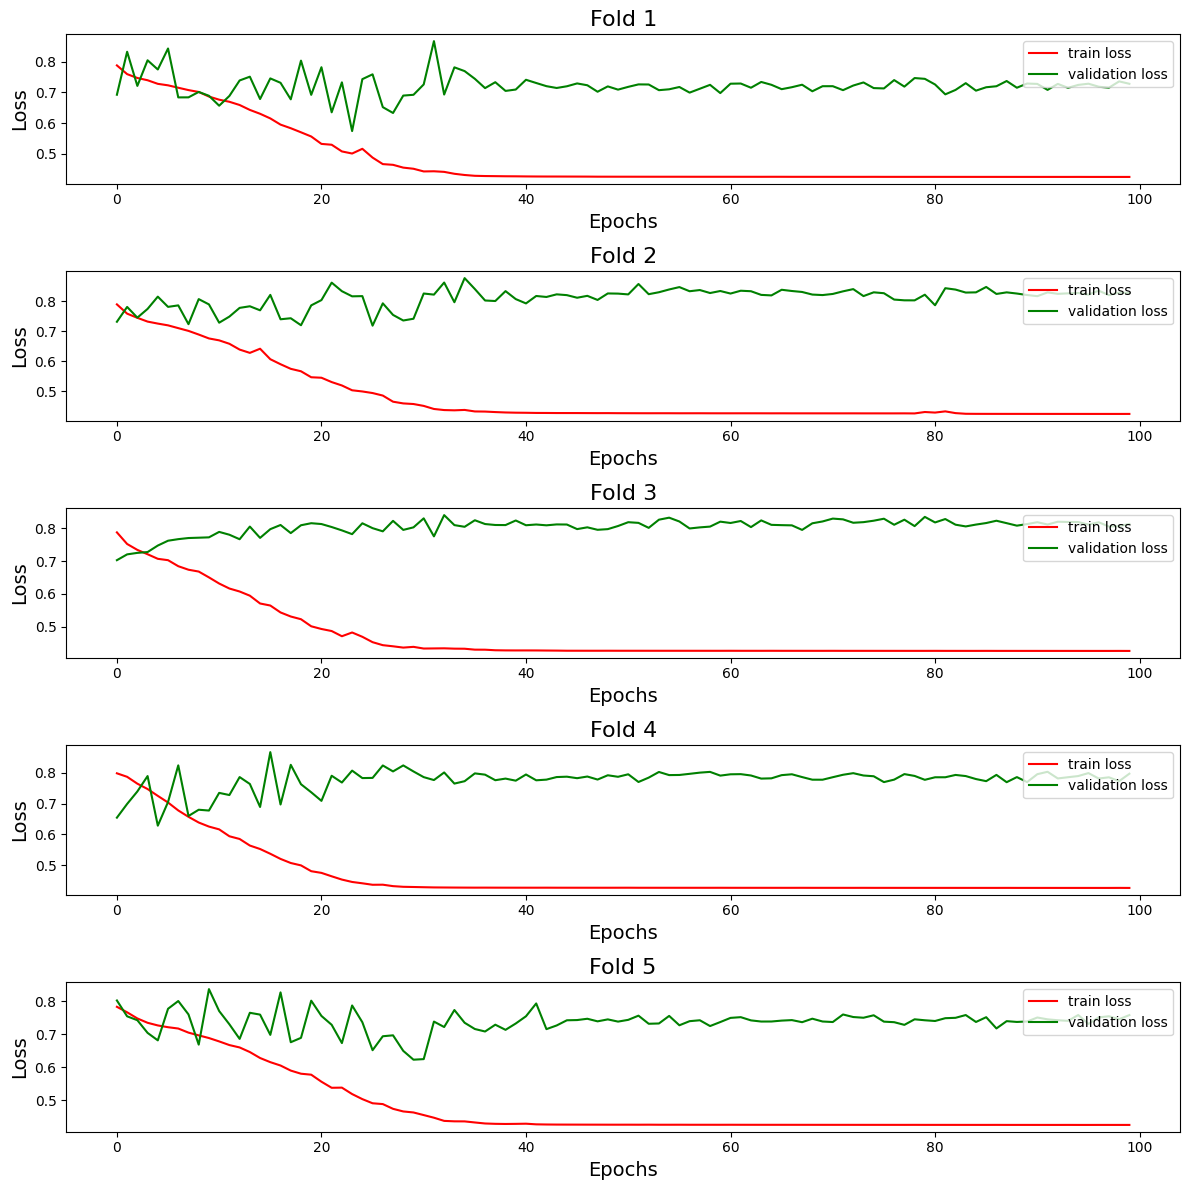

In [27]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(5, 1, figsize=(12, 12))

for i, ax in enumerate(axs.flatten()):
    ax.plot(tL[i],'-r')
    ax.plot(vL[i],'-g')
    ax.legend(['train loss', 'validation loss'],loc ="upper right")
    ax.set_title(f'Fold {i+1}', fontsize=16)
    ax.set_xlabel('Epochs', fontsize=14)
    ax.set_ylabel('Loss', fontsize=14)

plt.tight_layout()
plt.show()

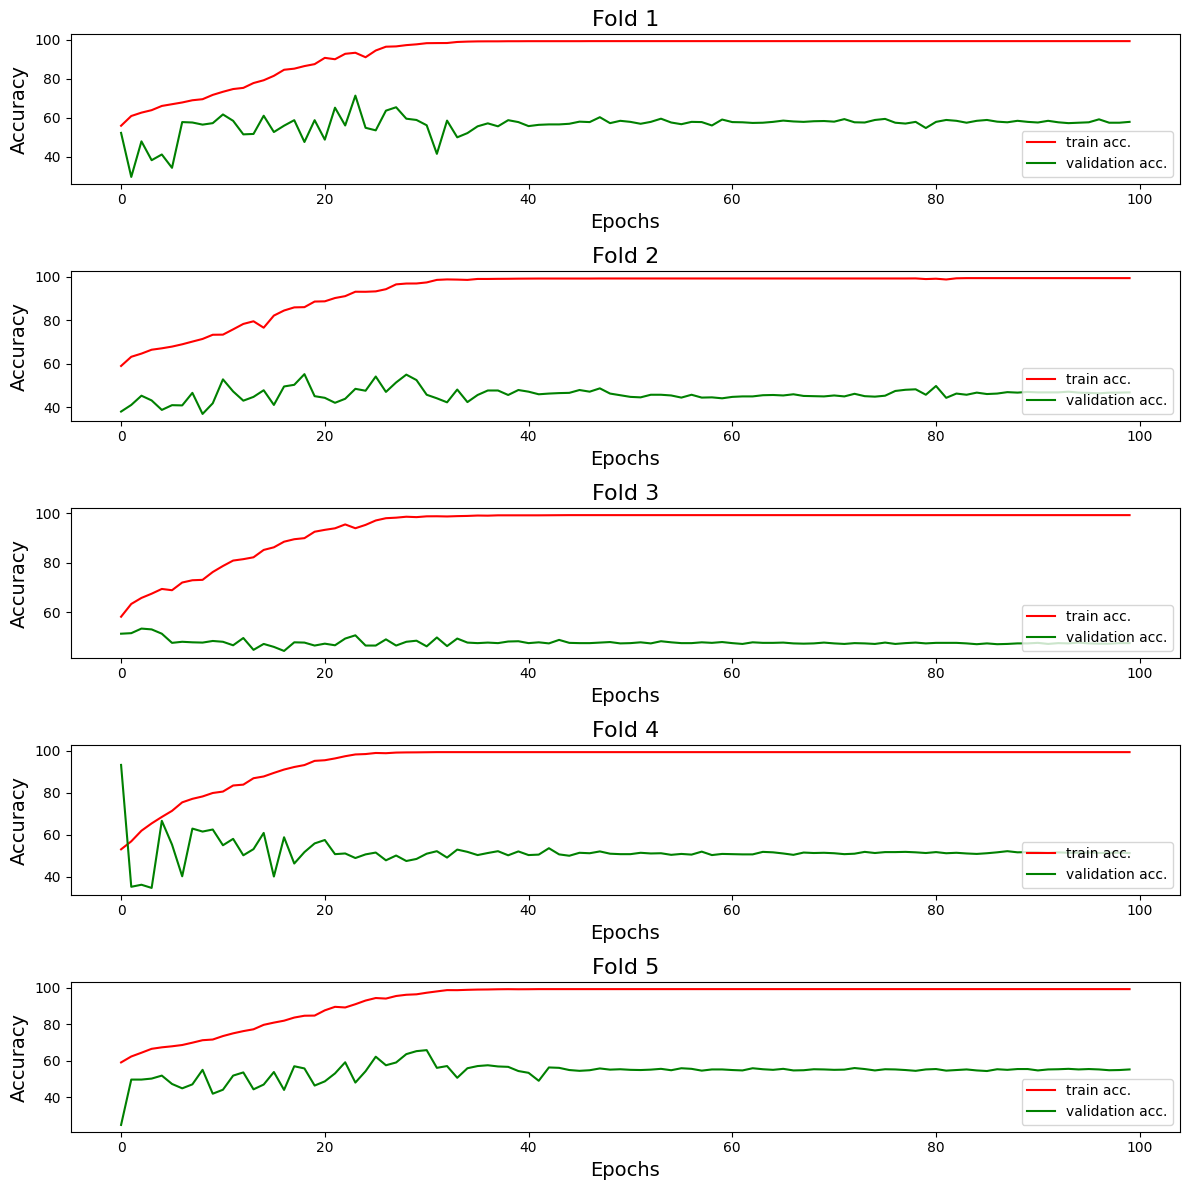

In [28]:
fig, axs = plt.subplots(5,1, figsize=(12, 12))

for i, ax in enumerate(axs.flatten()):
    ax.plot(tAV[i],'-r')
    ax.plot(vAV[i],'-g')
    ax.legend(['train acc.', 'validation acc.'],loc ="lower right")
    ax.set_title(f'Fold {i+1}', fontsize=16)
    ax.set_xlabel('Epochs', fontsize=14)
    ax.set_ylabel('Accuracy', fontsize=14)

plt.tight_layout()
plt.show()

In [29]:
tr = []
pred_gt_tuple = []
for key,value in log_pred_dict.items():
    tr.append(value['trails'])
    pred = torch.cat((value['predicted']),0)
    ground_truth = torch.cat((value['ground truth']),0)
    p = pred.to('cpu').numpy()
    g = ground_truth.to('cpu').numpy()
    print(p.shape)
    print(g.shape)
    pred_gt_tuple.append([p,g])

(920,)
(920,)
(920,)
(920,)
(920,)
(920,)
(920,)
(920,)
(920,)
(920,)


In [30]:
pred.shape

torch.Size([920])

In [31]:
log = {'trials': tr,
       'pred_gt': pred_gt_tuple}

In [32]:
scipy.io.savemat('./logs/COH_PLI_PSD_s15_a.mat',log)